MIT License

Copyright (c) 2020 José Luis Cervantes Varela

<h1><center> Análisis de COVID - 19 en México 2020 </center></h1>

# Contexto

¡Hola! El presente trabajo tiene como finalidad mostrar el análisis del COVID-19 en los diversos estados de la República Méxicana. Cabe mencionar que no soy un experto  en temas de COVID, el objetivo de este análisis es mostrar por medio de técnicas de Data Science, el resultados que se obtienen de los datos. Si tienen algún comentario con respecto al trabajo, su feedback es bienvenido.

Me presento, mi nombre es José Luis Cervantes Varela soy Ingeniero en Telemática y estudiante de la Licenciatura en Matemáticas, me gusta mucho jugar videojuegos de estrategía, soy un amante de los animales y sobretodo un aficionado del fútbol (aunque posiblemente a muchos no les agrade) y de las series de comedia.

Una de mis pasiones en esta vida es analizar y mostrar resultados, así que en esta ocasion les presento un análisis que realice refente al COVID-19 en mi tiempo libre.

Antes de comenzar debemos recordar como emergió el COVID-19, para ello es importante recordar el brote. 
En la página oficial de la OMS se mantiene la declaración actualiza continuamente, en función de la evolución de la situación y las consultas más frecuentes de los medios de comunicación, referente a la [cronología de la actuación de la OMS](https://www.who.int/es/news-room/detail/27-04-2020-who-timeline---covid-19)


In [1]:
#Se importan las librerías correspondientes.
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import matplotlib.patches as mpatches
import seaborn as sn
import requests, zipfile, io
from matplotlib import colors as mcolors
import numpy as np
import geopandas as gpd
import shapefile as shp
import imgkit
#import warnings
#warnings.filterwarnings('ignore')

C:\Users\dell7559\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



La [Dirección General de Epidemiología](https://www.gob.mx/salud/documentos/datos-abiertos-152127?fbclid=IwAR0sgH6nNmRBNbZmHpmWlxWwxFc6r9JM_nrLfT6E4RnaaZP2VBMLhcUHmJs) proporciona Datos Abiertos del cual se obtiene la base de datos actualizada día por dia y el diccionario de datos correspondiente

Se ejecutan las peticiones correpondientes para la descarga de los archivos mencionados,enseguida se realiza la extracción y la lectura, creando los dataframes correspondientes:
- datos_n: Posee todos los datos correspondientes a los contagios.
- entidades: Posee las entidades del país de México.
- municipios: Contiene las claves de todos los municipios del país.

In [2]:
zip_file_url='http://187.191.75.115/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
d=z.extractall()
datos_covid=z.namelist()
datos_n=pd.read_csv(datos_covid[0], encoding='latin')

In [3]:
zip_file_dict='http://187.191.75.115/gobmx/salud/datos_abiertos/diccionario_datos_covid19.zip'
req_dict = requests.get(zip_file_dict)
zip_dict = zipfile.ZipFile(io.BytesIO(req_dict.content))
zip_dict.extractall()
dict_covid=zip_dict.namelist()
entidades=pd.read_excel(dict_covid[0],  sheet_name="Catálogo de ENTIDADES")
municipios=pd.read_excel(dict_covid[0],  sheet_name="Catálogo MUNICIPIOS")
municipios.head()

CLAVE_MUNICIPIO       MUNICIPIO  CLAVE_ENTIDAD
0                1  AGUASCALIENTES              1
1                2        ASIENTOS              1
2                3        CALVILLO              1
3                4           COSÍO              1
4                5     JESÚS MARÍA              1

Dimensiones de los datos de los casos de SARS-COVID19

In [4]:
datos_n.shape

(169097, 35)

A continuación, se muestra la información característica de los datos correspondientes del dataframe y se puede ver, que no existen datos nulos y que la tabla esta muy bien construida, por lo que en el proceso de Data Wrangling, no sera necesario realizar el proceso de eliminacion de nulos.

In [5]:
datos_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169097 entries, 0 to 169096
Data columns (total 35 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   FECHA_ACTUALIZACION  169097 non-null  object
 1   ID_REGISTRO          169097 non-null  object
 2   ORIGEN               169097 non-null  int64 
 3   SECTOR               169097 non-null  int64 
 4   ENTIDAD_UM           169097 non-null  int64 
 5   SEXO                 169097 non-null  int64 
 6   ENTIDAD_NAC          169097 non-null  int64 
 7   ENTIDAD_RES          169097 non-null  int64 
 8   MUNICIPIO_RES        169097 non-null  int64 
 9   TIPO_PACIENTE        169097 non-null  int64 
 10  FECHA_INGRESO        169097 non-null  object
 11  FECHA_SINTOMAS       169097 non-null  object
 12  FECHA_DEF            169097 non-null  object
 13  INTUBADO             169097 non-null  int64 
 14  NEUMONIA             169097 non-null  int64 
 15  EDAD                 169097 non-nu

Se crea una funcion dedicada, la cual se utiliza para realizar una búsqueda específica, para conocer la cantidad de contagiados, sospechosos o que dieron negativo a la prueba del COVID.

In [6]:
def cantidad(entidad,muni,res):
    datos_h=datos_n.loc[datos_n["ENTIDAD_RES"]==int(entidad)]
    datos_t=datos_h.loc[datos_h["MUNICIPIO_RES"]==int(muni)]
    datos_t_c=datos_t.loc[datos_t["RESULTADO"]==int(res)]
    datos_t_c=datos_t_c.sort_values("FECHA_INGRESO")
    display(HTML(datos_t_c.to_html()))
    print(len(datos_t_c))

In [102]:
entidad=input("Que entidad buscas?")
muni=input("Que Municipio buscas?")
resultado=input("Que resultado buscas?")
cantidad(entidad,muni,resultado)

Que entidad buscas?13
Que Municipio buscas?69
Que resultado buscas?1


97


In [8]:
datos_df=datos_n.loc[datos_n["FECHA_DEF"]!="9999-99-99"]
set(datos_df["RESULTADO"])


{1, 2, 3}

Por ende a continuación, se hace la comparación de defunsiones, haciendo enfásis en su causa.

In [9]:
res_caso=[]
res_caso.append(datos_df.loc[datos_df["RESULTADO"]==1])
res_caso.append(datos_df.loc[datos_df["RESULTADO"]==2])
res_caso.append(datos_df.loc[datos_df["RESULTADO"]==3])
print("El número de defunciones por covid-19: ",len(res_caso[0]))
print("El número de defunciones que no son por covid-19: ",len(res_caso[1]))
print("El número de defunciones sin definir la causa todavía: ",len(res_caso[2]))

El número de defunciones por covid-19:  5045
El número de defunciones que no son por covid-19:  1946
El número de defunciones sin definir la causa todavía:  535


Enseguida se presentan las defunciones que hay por día, con causa confirmada del COVID.

cantidad de defunsiones totales:  5045


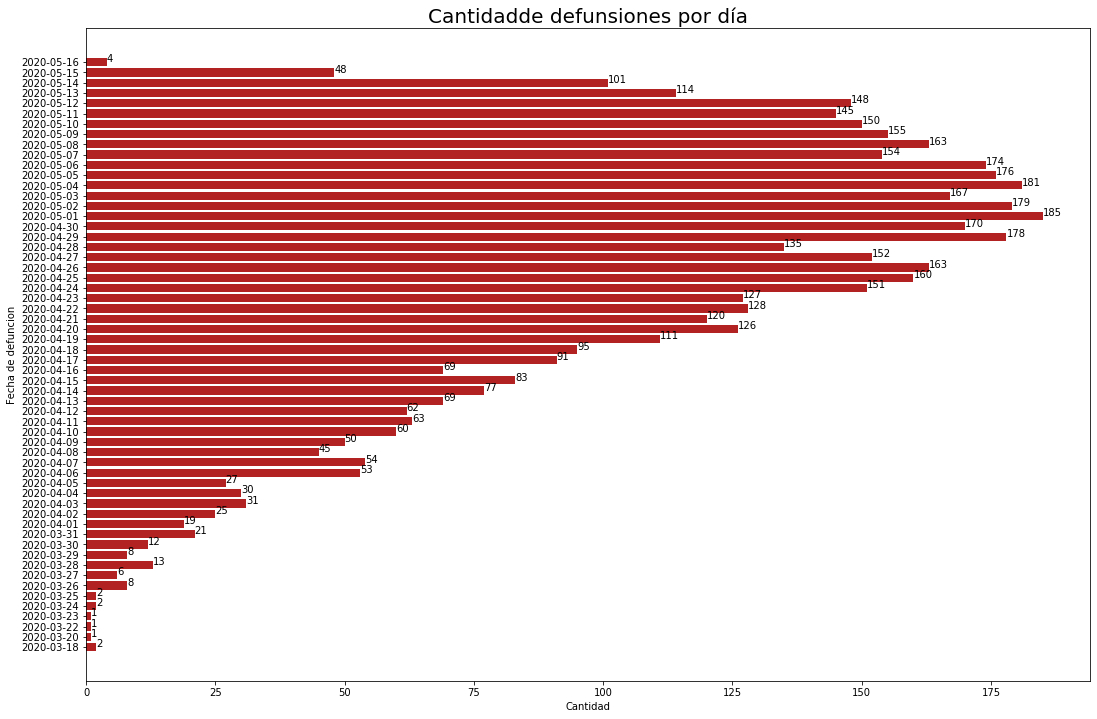

In [10]:
fecha_def=res_caso[0]["FECHA_DEF"]
print("cantidad de defunsiones totales: ",len(fecha_def))
feha_def_group=fecha_def.groupby(fecha_def).describe().reset_index()
plt.figure(figsize=(18,12))
plt.title("Cantidadde defunsiones por día",fontsize=20)
plt.barh(feha_def_group[feha_def_group.columns[0]].astype(str),feha_def_group["count"],color="firebrick")
plt.xlabel("Cantidad")
plt.ylabel("Fecha de defuncion")
for i,z in zip(feha_def_group[feha_def_group.columns[0]], feha_def_group["count"]):
    plt.text(x=z,y=i,s=z, ha='left', va='baseline')
plt.show()

En elsiguiente gráfico, se presentan las defunsiones acumuladas, por día.

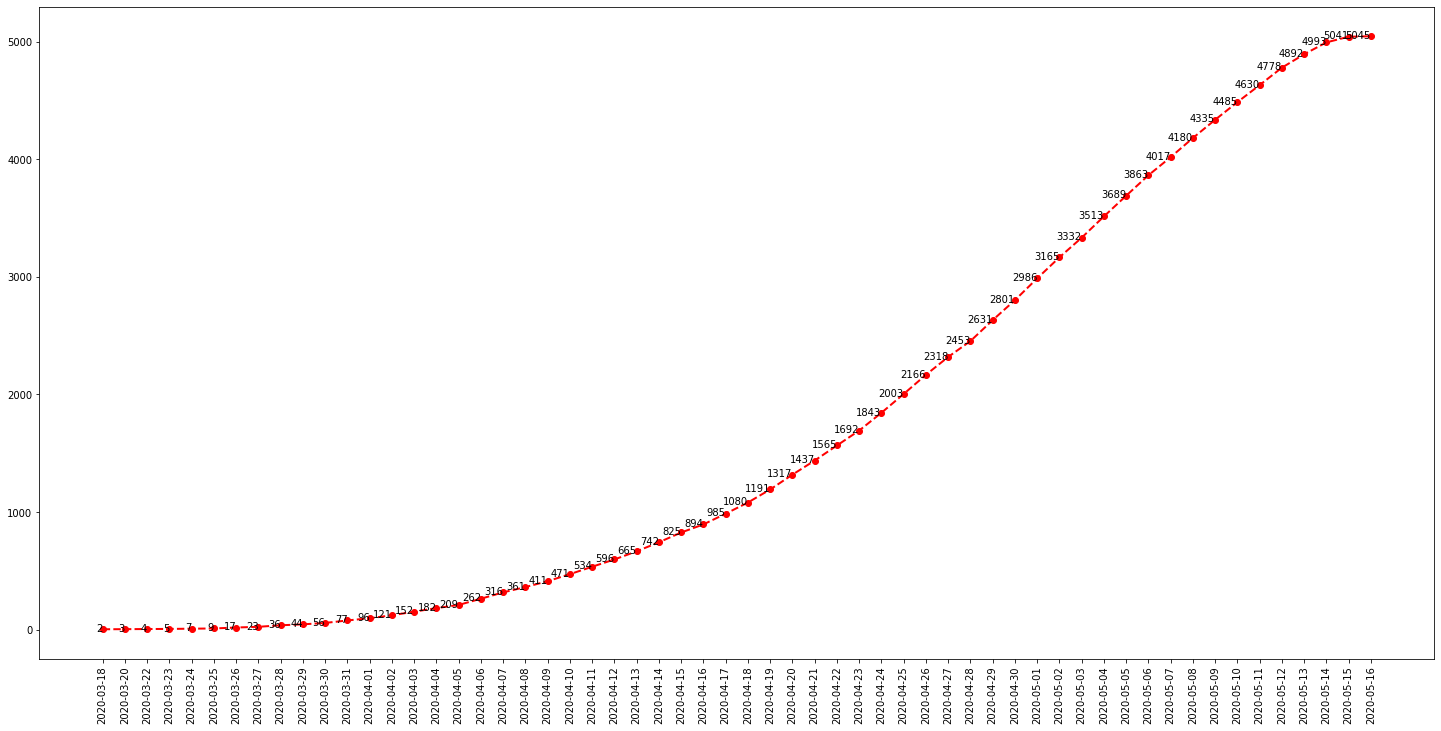

In [11]:
con_def=datos_n["FECHA_DEF"].loc[(datos_n["RESULTADO"]==1) & (datos_n["FECHA_DEF"]!='9999-99-99')]
con_def=con_def.groupby(con_def).describe().reset_index()
con_def=con_def.sort_values("FECHA_DEF")
con_def["Acumulados"]=con_def["count"].cumsum()
con_def
plt.figure(figsize=(25,12))
plt.plot( 'FECHA_DEF', 'Acumulados', data=con_def, color="red", linestyle='dashed',marker='o', linewidth=2)
plt.xticks(rotation = 90)
for i,z in zip(con_def['FECHA_DEF'], con_def['Acumulados']):
    plt.text(x=i,y=z+50,s=z, ha='right', va='top')
plt.show()

Para obtener más detalle con la información, se utiliza un diagrama de barras para poder visualizar el tipo de Nacionalidades de procedencia(nacionalidad extranjera) de los infectados de COVID.

Cantidad de personas con Covid, de distinta nacionalidad y su procedencia:  1501


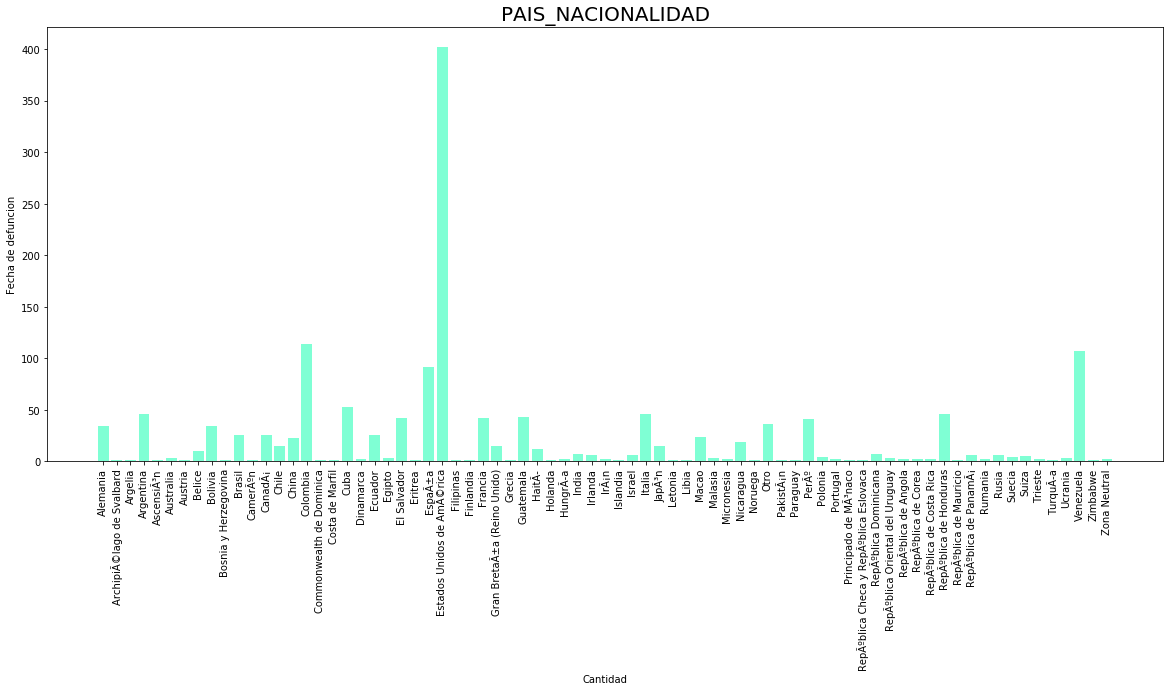

In [12]:
Nacionalidades=datos_n[["RESULTADO","MIGRANTE","PAIS_NACIONALIDAD","PAIS_ORIGEN"]]
Nacion_org=Nacionalidades["PAIS_NACIONALIDAD"].loc[(Nacionalidades["PAIS_NACIONALIDAD"]!='MÃ©xico') & (Nacionalidades["PAIS_NACIONALIDAD"]!='México') & (Nacionalidades["PAIS_NACIONALIDAD"]!='99')]
print("Cantidad de personas con Covid, de distinta nacionalidad y su procedencia: ",len(Nacion_org))
Nacion_group=Nacion_org.groupby(Nacion_org).describe().reset_index()
plt.figure(figsize=(20,8))
plt.title(Nacion_group.columns[0], fontsize=20)
plt.bar(Nacion_group[Nacion_group.columns[0]].astype(str),Nacion_group["count"],color="aquamarine")
plt.xlabel("Cantidad")
plt.ylabel("Fecha de defuncion")
plt.xticks(rotation = 90)
plt.show()

In [13]:
plt.figure(figsize=(20,20))
fig = px.bar(Nacion_group, x='PAIS_NACIONALIDAD', y='count')
fig.show()

<Figure size 1440x1440 with 0 Axes>

Se procede a realizar la extracción, únicamente los datos de las edades de las personas que han sufrido contagio, esto se puede apreciar en la gráfica.

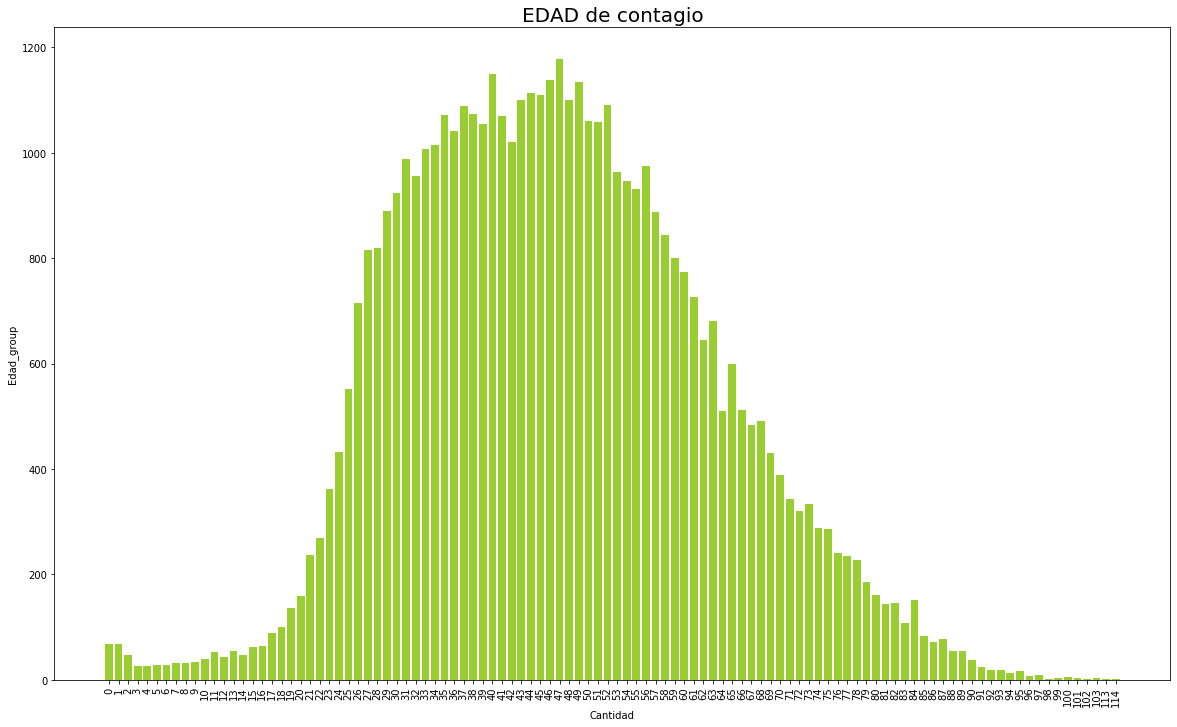

In [4]:
Edad_con=datos_n["EDAD"].loc[datos_n["RESULTADO"]==1]
Edad_con
Edad_group_con=Edad_con.groupby(Edad_con).describe().reset_index()
plt.figure(figsize=(20,12))
plt.title(Edad_group_con.columns[0]+" de contagio", fontsize=20)
plt.bar(Edad_group_con[Edad_group_con.columns[0]].astype(str),Edad_group_con["count"],color="yellowgreen")
plt.xlabel("Cantidad")
plt.ylabel("Edad_group")
plt.xticks(rotation = 90)
plt.show()

In [48]:
Edad_con.to_csv('D:/UNAD/carrera/Estadistica basica/unidad 3/Edad_con.csv')

In [5]:
cm = sn.light_palette("seagreen", as_cmap=True)
styled_table = Edad_group_con.style.background_gradient(cmap=cm).to_excel("nombre.xlsx")
Edad_group_con.style.background_gradient(cmap=cm)

Por ende se obtienen los datos de las edades de defunciones, pero unicamente de las personas que han sido corroborados como casos positivos.

5045


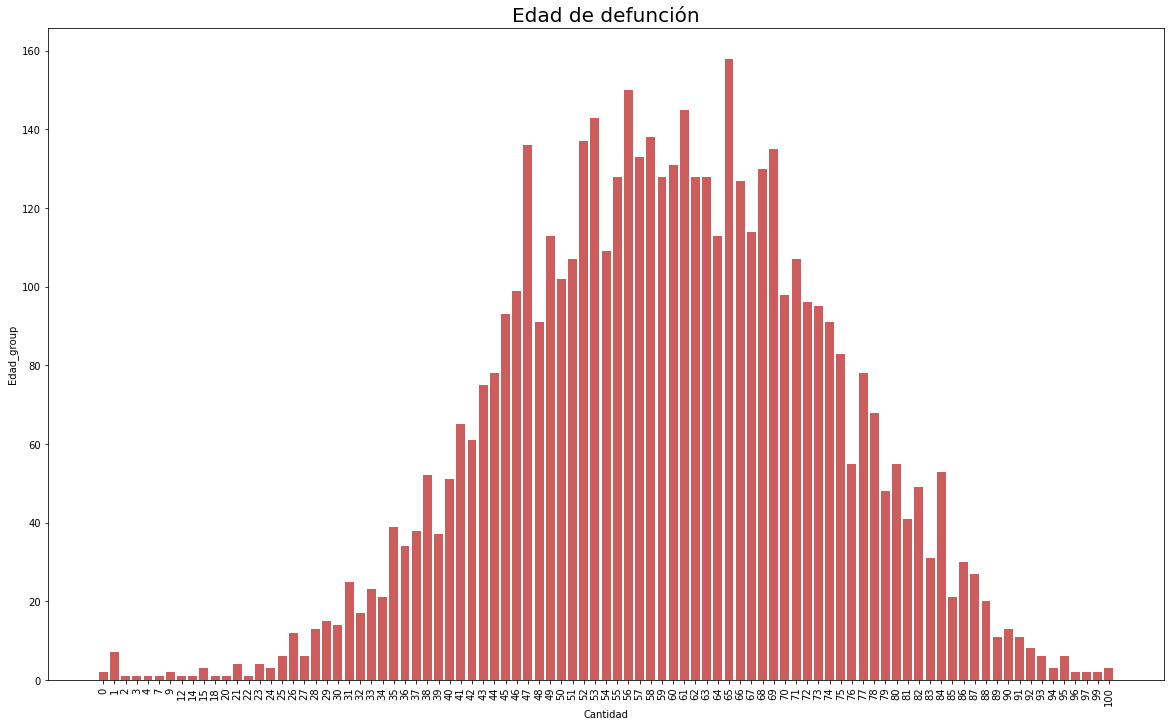

In [16]:
Edad_def=datos_n[["EDAD","FECHA_DEF","RESULTADO"]]
#Nacion_org=Nacionalidades["PAIS_NACIONALIDAD"]
Edad_def_fil=Edad_def["EDAD"].loc[(Edad_def["FECHA_DEF"]!='9999-99-99') & (Edad_def["RESULTADO"]==1)]
print(len(Edad_def_fil))
Edad_def_group=Edad_def_fil.groupby(Edad_def_fil).describe().reset_index()
#Edad_def_group
plt.figure(figsize=(20,12))
plt.title("Edad de defunción", fontsize=20)
plt.bar(Edad_def_group[Edad_def_group.columns[0]].astype(str),Edad_def_group["count"],color="indianred")
plt.xlabel("Cantidad")
plt.ylabel("Edad_group")
plt.xticks(rotation = 90)
plt.show()

Se quiere realizar la comparación de días que transcurren entre la fecha de los sintomas del paciente y su fecha de ingreso.

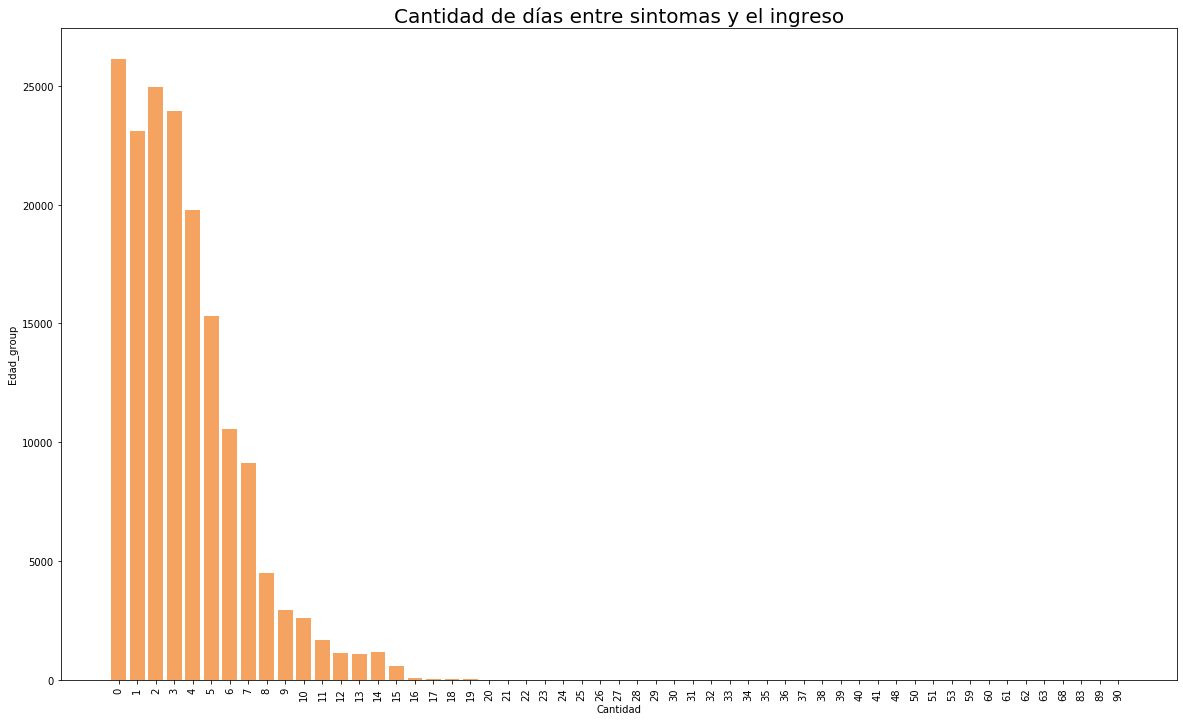

3074.490909090909


In [17]:
dif_dias=[]
Fechas_=datos_n[["FECHA_INGRESO","FECHA_SINTOMAS"]]
for i in range(len(Fechas_)):
    fecha=Fechas_["FECHA_INGRESO"][i]
    fecha2=Fechas_["FECHA_SINTOMAS"][i]
    f1=datetime.strptime(fecha, '%Y-%m-%d').date()
    f2=datetime.strptime(fecha2, '%Y-%m-%d').date()
    dif_dias.append((f1-f2).days)
dif_dias=pd.Series(dif_dias)
dif_dias_group=dif_dias.groupby(dif_dias).describe().reset_index()
pd.Series(dif_dias)
#Edad_def_group
plt.figure(figsize=(20,12))
plt.title("Cantidad de días entre sintomas y el ingreso",fontsize=20)
plt.bar(dif_dias_group[dif_dias_group.columns[0]].astype(str),dif_dias_group["count"],color="sandybrown")
plt.xlabel("Cantidad")
plt.ylabel("Edad_group")
plt.xticks(rotation = 90)
plt.show()
print(dif_dias_group["count"].mean())

Se realiza la comparación de días que transcurren entre la fecha de internado del paciente y su fecha de defunsion.

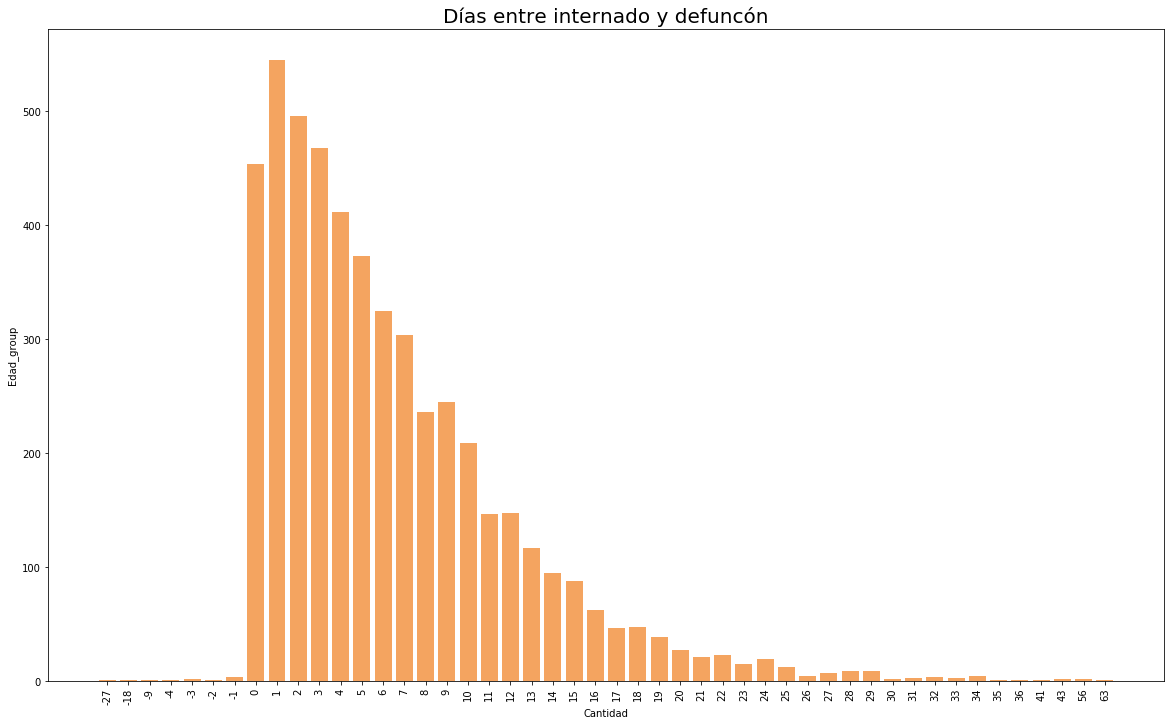

105.10416666666667


In [18]:
dif_dias_def=[]
Fechas_=datos_n[["FECHA_INGRESO","FECHA_DEF","RESULTADO"]]
Fechas_fil=Fechas_.loc[(Fechas_["RESULTADO"]==1) & (Edad_def["FECHA_DEF"]!='9999-99-99')].reset_index()
for i in range(len(Fechas_fil)):
    fecha_in=Fechas_fil["FECHA_INGRESO"][i]
    fecha2_def=Fechas_fil["FECHA_DEF"][i]
    f1_in=datetime.strptime(fecha_in, '%Y-%m-%d').date()
    f2_df=datetime.strptime(fecha2_def, '%Y-%m-%d').date()
    dif_dias_def.append((f2_df-f1_in).days)
dif_dias_def=pd.Series(dif_dias_def)
dif_dias_group_def=dif_dias_def.groupby(dif_dias_def).describe().reset_index()
pd.Series(dif_dias_def)
#Edad_def_group
plt.figure(figsize=(20,12))
plt.title("Días entre internado y defuncón",fontsize=20)
plt.bar(dif_dias_group_def[dif_dias_group_def.columns[0]].astype(str),dif_dias_group_def["count"],color="sandybrown")
plt.xlabel("Cantidad")
plt.ylabel("Edad_group")
plt.xticks(rotation = 90)
plt.show()
print(dif_dias_group_def["count"].mean())

En seguida, se realiza el calculo de los contagios acumulados, por fecha.

In [19]:
conteo=datos_n[["FECHA_INGRESO","RESULTADO","FECHA_DEF"]].loc[(datos_n["RESULTADO"]==1)]# & (datos_n["FECHA_INGRESO"]=='2020-04-19')]
conteo=conteo.groupby(conteo["FECHA_INGRESO"]).count().reset_index()
conteo=conteo.sort_values("FECHA_INGRESO")
conteo["Acumulados"]=conteo["RESULTADO"].cumsum()
conteo

FECHA_INGRESO  RESULTADO  FECHA_DEF  Acumulados
0     2020-01-08          1          1           1
1     2020-01-14          1          1           2
2     2020-01-28          1          1           3
3     2020-01-31          1          1           4
4     2020-02-07          1          1           5
..           ...        ...        ...         ...
77    2020-05-11       1887       1887       43440
78    2020-05-12       1555       1555       44995
79    2020-05-13       1371       1371       46366
80    2020-05-14        649        649       47015
81    2020-05-15        129        129       47144

[82 rows x 4 columns]

Se representan los datos acumulados de contagios en una gráfica que va de forma  exponencial.

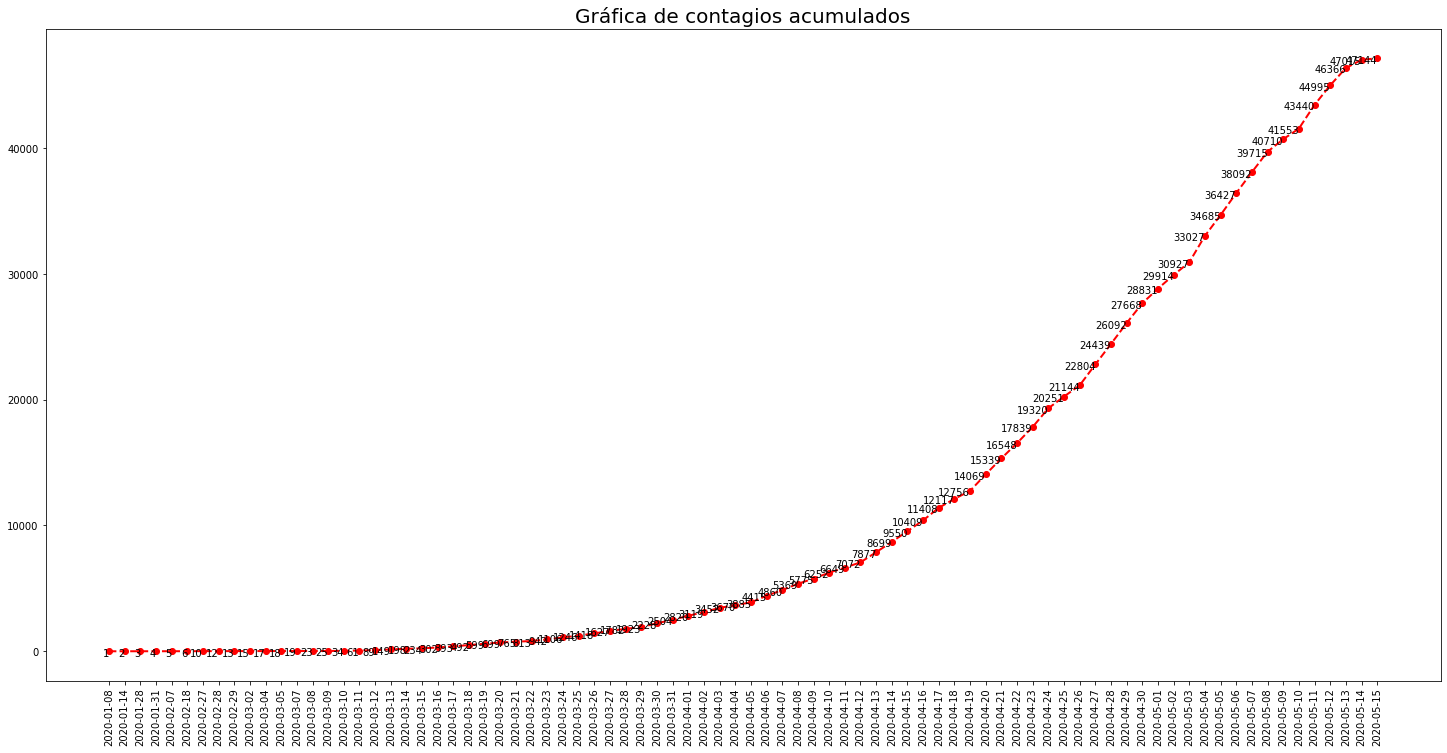

In [20]:
plt.figure(figsize=(25,12))
plt.plot( 'FECHA_INGRESO', 'Acumulados', data=conteo, color="red", linestyle='dashed',marker='o', linewidth=2)
plt.xticks(rotation = 90)
plt.title("Gráfica de contagios acumulados", fontsize=20)
for i,z in zip(conteo['FECHA_INGRESO'], conteo['Acumulados']):
    plt.text(x=i,y=z+250,s=z, ha='right', va='top')
plt.show()

Se realiza la misma representación anterior, pero haciendo uso de la librería "PLOTLY".

In [21]:
plt.figure(figsize=(25,12))
fig = px.line(conteo, x="FECHA_INGRESO", y="Acumulados")#,text="Acumulados")
fig.update_xaxes(tickangle=90, tickfont=dict(family='Rockwell', color='crimson', size=9))
#fig.update_traces(textposition='top center')
fig.update_layout(width=1000,height=500)
fig.show()

<Figure size 1800x864 with 0 Axes>

Se realiza una comparación entre el tipo de género  de los contagios.

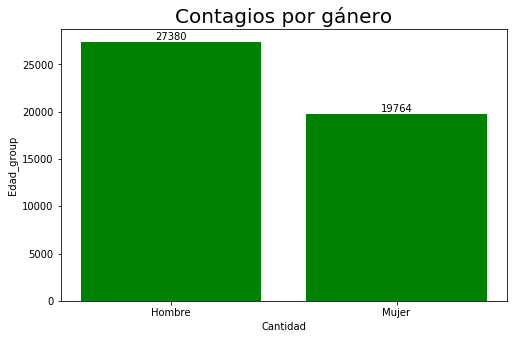

In [22]:
Genero=datos_n["SEXO"].loc[(datos_n["RESULTADO"]==1)]
result = Genero.replace(to_replace = [1, 2], value = ['Mujer', 'Hombre'])
result=result.groupby(result).describe().reset_index()
plt.figure(figsize=(8,5))
plt.title("Contagios por género", fontsize=20)
ax=plt.bar(result[result.columns[0]].astype(str),result["count"],color="green")
plt.xlabel("Cantidad")
plt.ylabel("Edad_group")
for rect in ax:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')
#plt.xticks(rotation = 90)
plt.show()

Se realiza una gráfica, que represente de manera sobrepuesta, toda la población que a sido estudiada, los que sufren de COVID, los que han dado negativo a la enfermedad y los que son casos sopechosos.

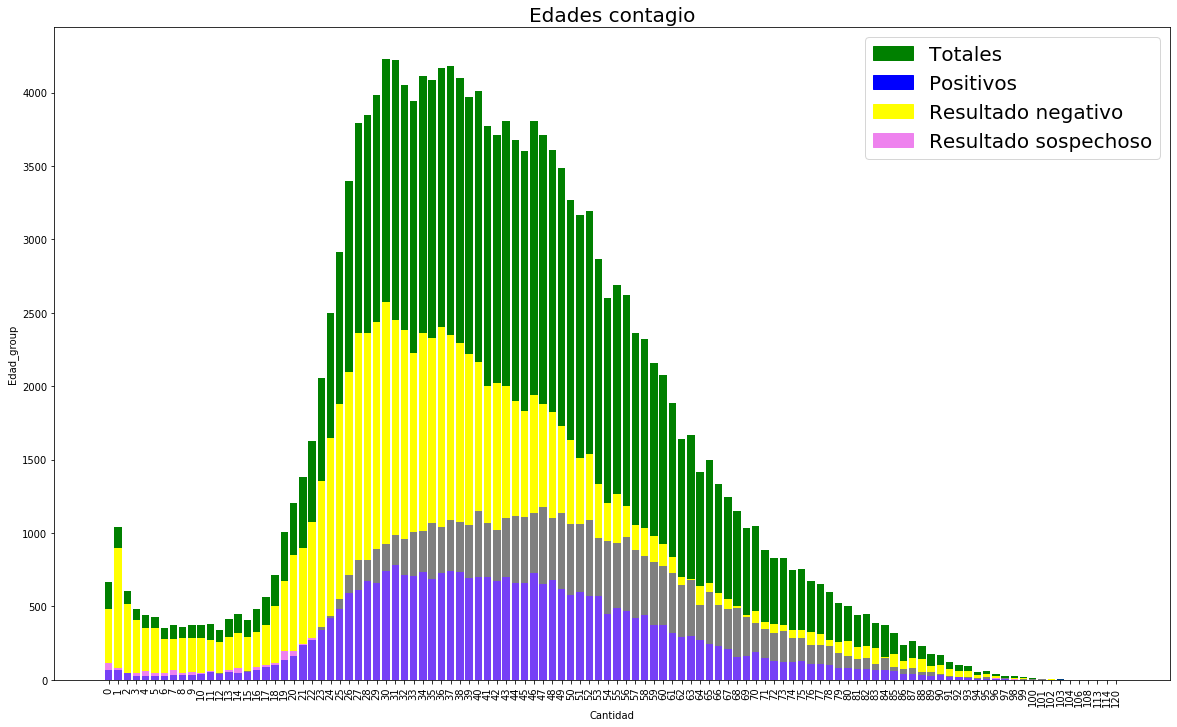

In [23]:
Edades=datos_n[["EDAD","RESULTADO"]]
Edades_pos=Edades["EDAD"].loc[(Edades["RESULTADO"]==1)]
Edades_neg=Edades["EDAD"].loc[(Edades["RESULTADO"]==2)]
Edades_sos=Edades["EDAD"].loc[(Edades["RESULTADO"]==3)]
Edades_tot=Edades["EDAD"]
Edad_tot_group=Edades_tot.groupby(Edades_tot).describe().reset_index()
Edad_pos_group=Edades_pos.groupby(Edades_pos).describe().reset_index()
Edad_neg_group=Edades_neg.groupby(Edades_neg).describe().reset_index()
Edad_sos_group=Edades_sos.groupby(Edades_sos).describe().reset_index()
plt.figure(figsize=(20,12))
plt.title("Edades contagio",fontsize=20)
plt.bar(Edad_tot_group[Edad_tot_group.columns[0]].astype(str),Edad_tot_group["count"],color="green")
plt.bar(Edad_neg_group[Edad_neg_group.columns[0]].astype(str),Edad_neg_group["count"],color="yellow")
plt.bar(Edad_sos_group[Edad_sos_group.columns[0]].astype(str),Edad_sos_group["count"],color="violet")
plt.bar(Edad_pos_group[Edad_pos_group.columns[0]].astype(str),Edad_pos_group["count"],color="blue",alpha=0.5)

green_patch = mpatches.Patch(color='green', label='Totales')
red_patch = mpatches.Patch(color='blue', label='Positivos')
yellow_patch = mpatches.Patch(color='yellow', label='Resultado negativo')
violet_patch = mpatches.Patch(color='violet', label='Resultado sospechoso')
plt.legend(handles=[green_patch,red_patch,yellow_patch,violet_patch],fontsize=20)

plt.xlabel("Cantidad")
plt.ylabel("Edad_group")
plt.xticks(rotation = 90)
plt.show()

Se procede a realizar dos tipos de filtrado, donde el primer filtrado de columnas, se eligieron por una parte, las correspondientes a las que pueden tener mayor relación con las causas de la enfermedad. El segundo filtro la relación de todas las variables cuyas opciones son representadas por resultados de opción múltiple.

In [24]:
corr=datos_n[['SEXO', 'TIPO_PACIENTE','INTUBADO', 'NEUMONIA',
       'EDAD', 'EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES',
       'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
       'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO',
       'OTRO_CASO', 'RESULTADO', 'MIGRANTE','UCI']]
si_no_num=datos_n[['INTUBADO', 'NEUMONIA','EMBARAZO', 'HABLA_LENGUA_INDIG', 'DIABETES','EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM',
                  'CARDIOVASCULAR', 'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO','OTRO_CASO', 'MIGRANTE']].loc[datos_n["RESULTADO"]==1]

De las opciones de opcion multiple, se procedio a realizar el remplazo de los datos de cada variable por los que vienen en el diccionario y posteriormente se llrvo  a cabo la gráficación de los mismos.

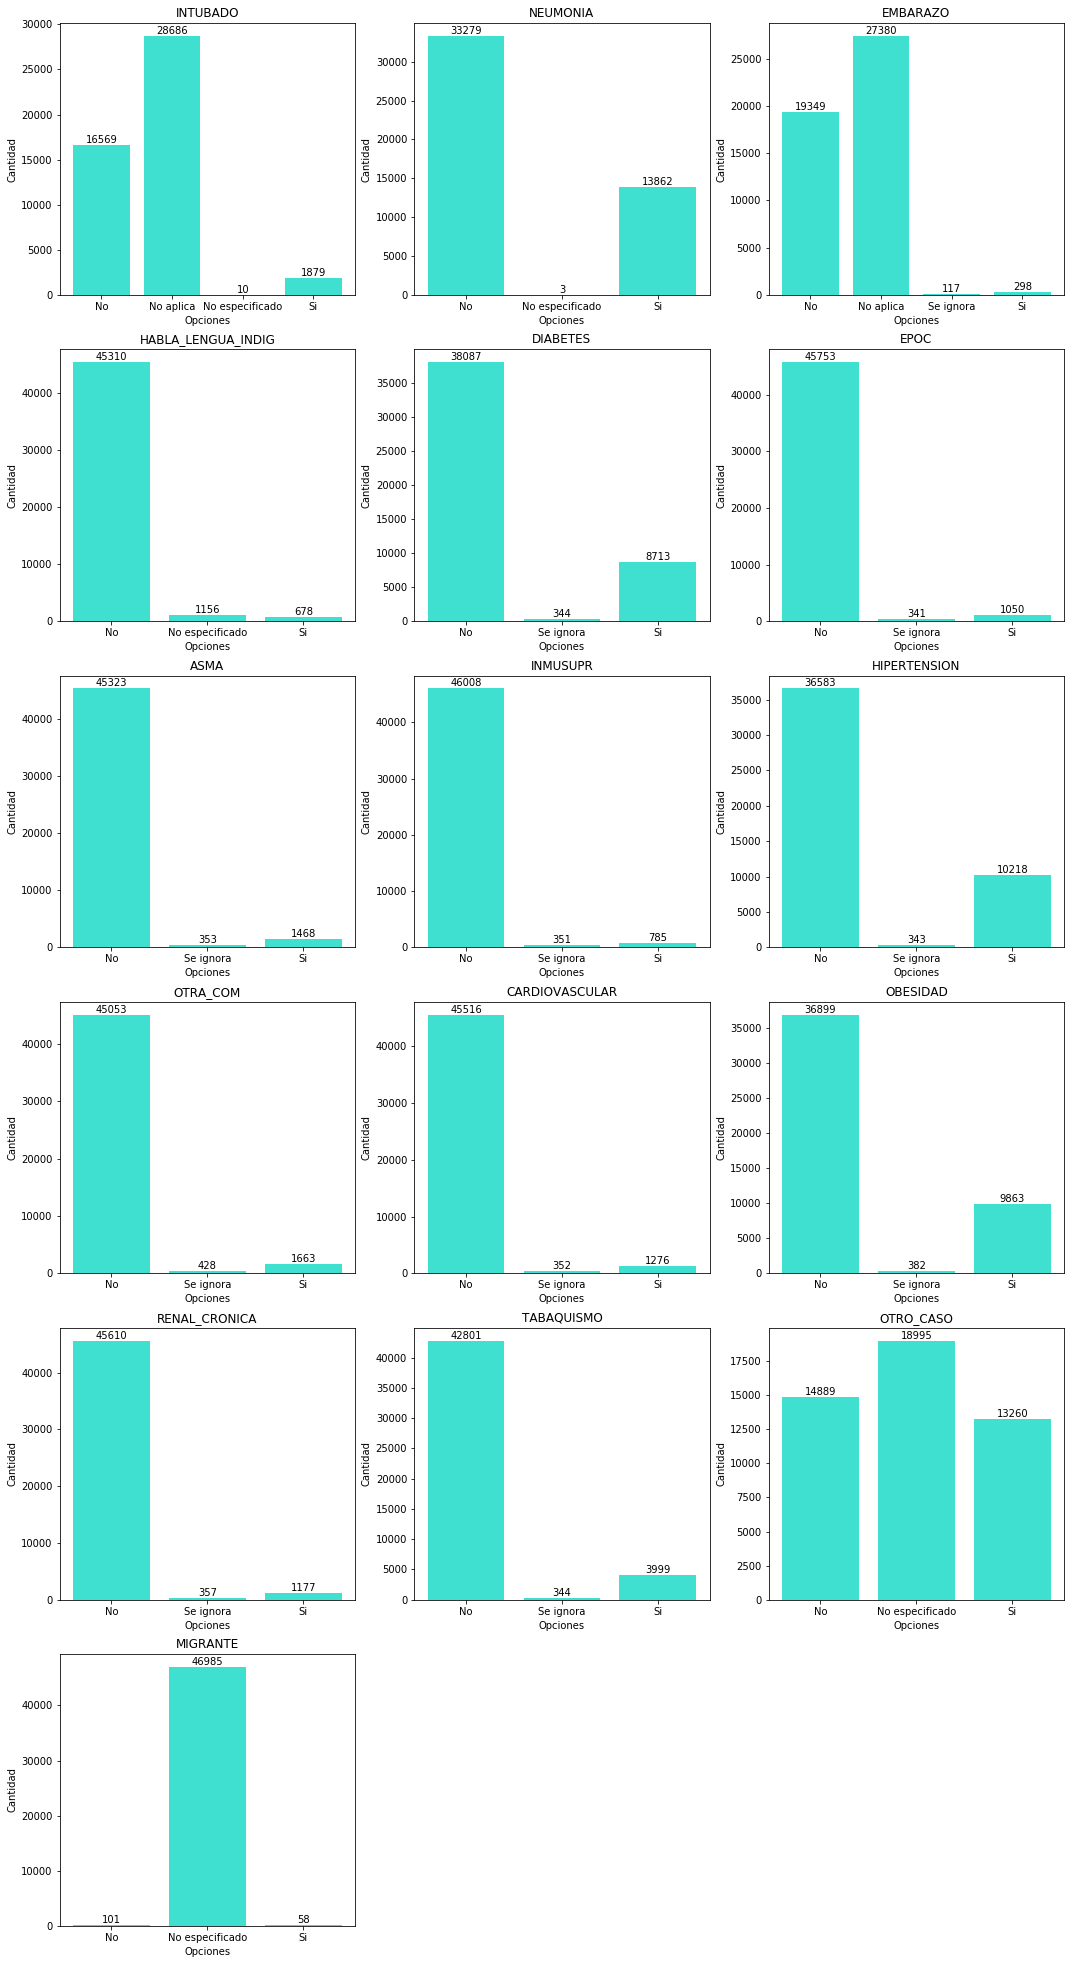

In [25]:
plt.figure(figsize=(18,35))
si_no=si_no_num.replace([1, 2, 97, 98, 99], ["Si","No","No aplica","Se ignora","No especificado"])
for i in range(len(si_no.columns)):
    si_no_group=si_no.iloc[:,i]
    si_no_group=si_no_group.groupby(si_no_group).describe().reset_index()
    #print(si_no_group)
    pos=i+1
    plt.subplot(6, 3, pos)
    plt.title(si_no_group.columns[0])
    dats=plt.bar(si_no_group[si_no_group.columns[0]].astype(str),si_no_group["count"],color="turquoise")
    plt.xlabel("Opciones")
    plt.ylabel("Cantidad")
    for rect in dats:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')
plt.show()

Para poder realizar la matriz de correlación, primero se crearon las variables dummies, para posteriormente generar la matriz. En este caso se puede observar que se quedo con un total de 21 variables.

In [26]:
dummies_ren=pd.get_dummies(corr)
corrMatrix = dummies_ren.corr()
len(corrMatrix)

21

Se hace uso de la librería de seaborn, para la graficacion de la matriz.

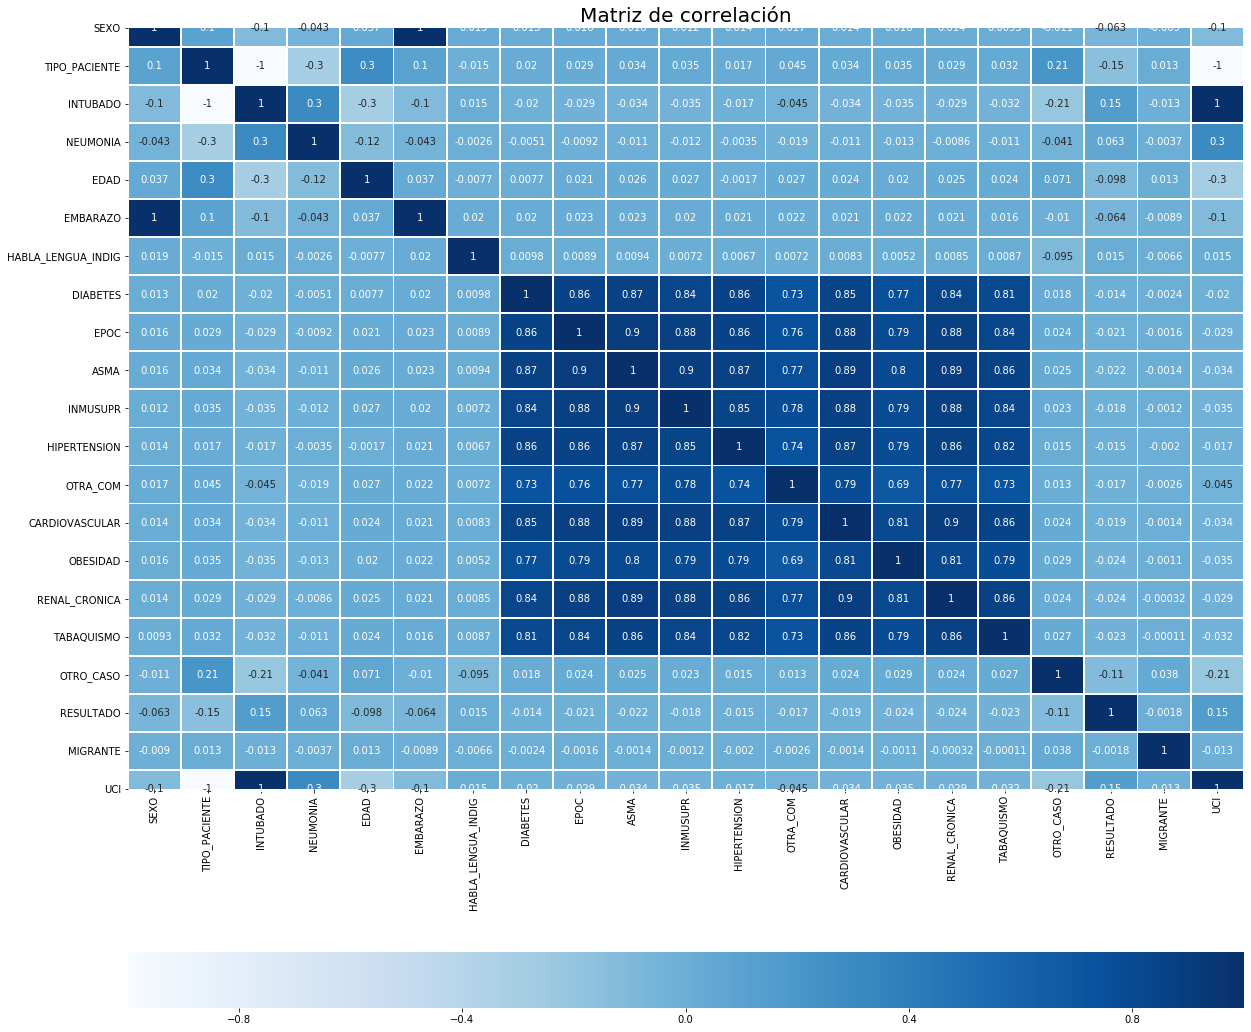

In [27]:
plt.figure(figsize=(20,20))
g=sn.heatmap(corrMatrix, annot=True,linewidths=.8,cmap="Blues",cbar_kws={"orientation":"horizontal"})
plt.title("Matriz de correlación",fontsize=20)
plt.show()

Se procedio a realizar un diagrama de caja de todas las variables numericas que contiene el dataset. en el cual se puede observar que la mayoría de ellas no proporciona mucha información, por el tipo de infrmación que provee.

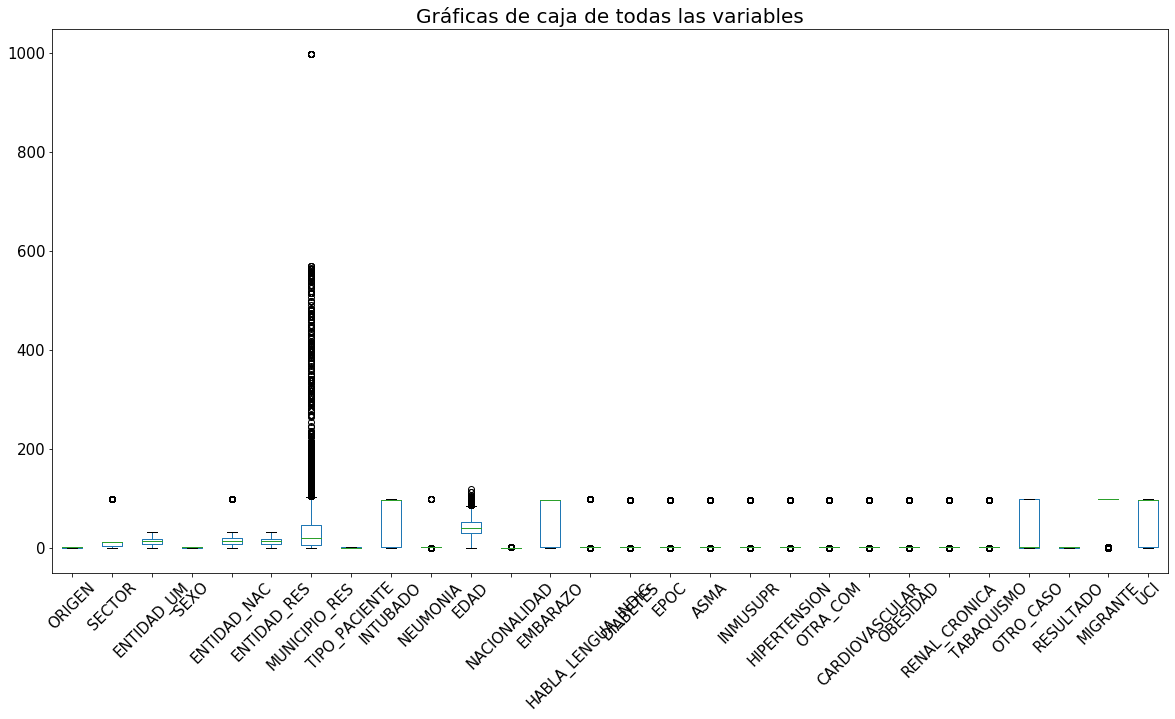

In [28]:
boxplot = datos_n.boxplot(grid=False, rot=45, fontsize=15,figsize=(20,10))
plt.title("Gráficas de caja de todas las variables",fontsize=20)
plt.show()

Se obtuviron y se generon las gráficas de caja de la variable de Edad. Cabe mencionar que la primer gráfica corresponde a todas las edades de la población analizada.

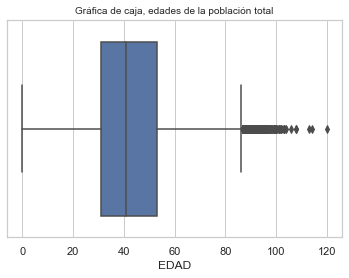

In [29]:
sn.set(style="whitegrid")
ax = sn.boxplot(x=datos_n["EDAD"])
plt.title("Gráfica de caja, edades de la población total",fontsize=10)
plt.show()

La suigiente gráfica corresponde solamente a las personas que están infectadas.

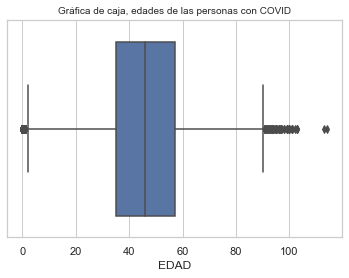

In [30]:
ed_boxplot=datos_n["EDAD"].loc[datos_n["RESULTADO"]==1]
sn.set(style="whitegrid")
ax = sn.boxplot(x=ed_boxplot)
plt.title("Gráfica de caja, edades de las personas con COVID",fontsize=10)
plt.show()

## Acumulados por Entidades y municipios

In [12]:
datos_es=datos_n[['ENTIDAD_UM','ENTIDAD_NAC','ENTIDAD_RES','MUNICIPIO_RES','FECHA_INGRESO','RESULTADO']].loc[datos_n["RESULTADO"]==1]

In [13]:
muni_fil=municipios.loc[municipios["CLAVE_ENTIDAD"]<33]
muni_fil

CLAVE_MUNICIPIO              MUNICIPIO  CLAVE_ENTIDAD
0                   1         AGUASCALIENTES              1
1                   2               ASIENTOS              1
2                   3               CALVILLO              1
3                   4                  COSÍO              1
4                   5            JESÚS MARÍA              1
...               ...                    ...            ...
2492               55             VILLANUEVA             32
2493               56              ZACATECAS             32
2494               57               TRANCOSO             32
2495               58  SANTA MARÍA DE LA PAZ             32
2496              999        NO ESPECIFICADO             32

[2497 rows x 3 columns]

In [14]:
ent_fil=entidades.drop([33,34,35])

In [15]:
union_entmun = pd.merge(ent_fil.reset_index(), muni_fil.reset_index(),
                    on=['CLAVE_ENTIDAD'], how='inner').set_index(['CLAVE_ENTIDAD'])
union_entmun=union_entmun.reset_index()
union_entmun

CLAVE_ENTIDAD  index_x ENTIDAD_FEDERATIVA ABREVIATURA  index_y  \
0                 1        0     AGUASCALIENTES          AS        0   
1                 1        0     AGUASCALIENTES          AS        1   
2                 1        0     AGUASCALIENTES          AS        2   
3                 1        0     AGUASCALIENTES          AS        3   
4                 1        0     AGUASCALIENTES          AS        4   
...             ...      ...                ...         ...      ...   
2492             32       31          ZACATECAS          ZS     2492   
2493             32       31          ZACATECAS          ZS     2493   
2494             32       31          ZACATECAS          ZS     2494   
2495             32       31          ZACATECAS          ZS     2495   
2496             32       31          ZACATECAS          ZS     2496   

      CLAVE_MUNICIPIO              MUNICIPIO  
0                   1         AGUASCALIENTES  
1                   2               ASIENTOS  
2                   3               CALVILLO  
3                   4                  COSÍO  
4                   5            JESÚS MARÍA  
...               ...                    ...  
2492               55             VILLANUEVA  
2493               56              ZACATECAS  
2494               57               TRANCOSO  
2495               58  SANTA MARÍA DE LA PAZ  
2496              999        NO ESPECIFICADO  

[2497 rows x 7 columns]

In [16]:
pru_en=datos_es.copy()
pru_en

ENTIDAD_UM  ENTIDAD_NAC  ENTIDAD_RES  MUNICIPIO_RES FECHA_INGRESO  \
0               9            9            9              6    2020-03-30   
1               5            5            5              6    2020-04-03   
2               3           25            3              8    2020-03-20   
3              27           27           27              2    2020-04-15   
4              15            9           15            122    2020-04-16   
...           ...          ...          ...            ...           ...   
47139          17           17           17             26    2020-05-05   
47140           9            9            9             16    2020-05-07   
47141          12           12           12             66    2020-05-01   
47142          15            9           15             33    2020-05-07   
47143          21           21           21             74    2020-05-07   

       RESULTADO  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
47139          1  
47140          1  
47141          1  
47142          1  
47143          1  

[47144 rows x 6 columns]

In [17]:
ex=[]
for i in range(0,33):
    ds=pru_en.loc[pru_en['ENTIDAD_RES']==i]
    ex_mun=union_entmun[['CLAVE_MUNICIPIO','MUNICIPIO']].loc[union_entmun['CLAVE_ENTIDAD']==i]
    dict_mun=ex_mun.set_index('CLAVE_MUNICIPIO').to_dict()['MUNICIPIO']
    print(dict_mun)
    ds['MUNICIPIO_RES']=pru_en['MUNICIPIO_RES'].loc[pru_en['ENTIDAD_RES']==i].replace(dict_mun)
    ex.append(ds)
origin=pd.concat(ex)
origin

{}
{1: 'AGUASCALIENTES', 2: 'ASIENTOS', 3: 'CALVILLO', 4: 'COSÍO', 5: 'JESÚS MARÍA', 6: 'PABELLÓN DE ARTEAGA', 7: 'RINCÓN DE ROMOS', 8: 'SAN JOSÉ DE GRACIA', 9: 'TEPEZALÁ', 10: 'EL LLANO', 11: 'SAN FRANCISCO DE LOS ROMO', 999: 'NO ESPECIFICADO'}
{1: 'ENSENADA', 2: 'MEXICALI', 3: 'TECATE', 4: 'TIJUANA', 5: 'PLAYAS DE ROSARITO', 999: 'NO ESPECIFICADO'}
{1: 'COMONDÚ', 2: 'MULEGÉ', 3: 'LA PAZ', 8: 'LOS CABOS', 9: 'LORETO', 999: 'NO ESPECIFICADO'}
{1: 'CALKINÍ', 2: 'CAMPECHE', 3: 'CARMEN', 4: 'CHAMPOTÓN', 5: 'HECELCHAKÁN', 6: 'HOPELCHÉN', 7: 'PALIZADA', 8: 'TENABO', 9: 'ESCÁRCEGA', 10: 'CALAKMUL', 11: 'CANDELARIA', 999: 'NO ESPECIFICADO'}
{1: 'ABASOLO', 2: 'ACUÑA', 3: 'ALLENDE', 4: 'ARTEAGA', 5: 'CANDELA', 6: 'CASTAÑOS', 7: 'CUATRO CIÉNEGAS', 8: 'ESCOBEDO', 9: 'FRANCISCO I. MADERO', 10: 'FRONTERA', 11: 'GENERAL CEPEDA', 12: 'GUERRERO', 13: 'HIDALGO', 14: 'JIMÉNEZ', 15: 'JUÁREZ', 16: 'LAMADRID', 17: 'MATAMOROS', 18: 'MONCLOVA', 19: 'MORELOS', 20: 'MÚZQUIZ', 21: 'NADADORES', 22: 'NAVA', 23: '

C:\Users\dell7559\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



{1: 'AMEALCO DE BONFIL', 2: 'PINAL DE AMOLES', 3: 'ARROYO SECO', 4: 'CADEREYTA DE MONTES', 5: 'COLÓN', 6: 'CORREGIDORA', 7: 'EZEQUIEL MONTES', 8: 'HUIMILPAN', 9: 'JALPAN DE SERRA', 10: 'LANDA DE MATAMOROS', 11: 'EL MARQUÉS', 12: 'PEDRO ESCOBEDO', 13: 'PEÑAMILLER', 14: 'QUERÉTARO', 15: 'SAN JOAQUÍN', 16: 'SAN JUAN DEL RÍO', 17: 'TEQUISQUIAPAN', 18: 'TOLIMÁN', 999: 'NO ESPECIFICADO'}
{1: 'COZUMEL', 2: 'FELIPE CARRILLO PUERTO', 3: 'ISLA MUJERES', 4: 'OTHÓN P. BLANCO', 5: 'BENITO JUÁREZ', 6: 'JOSÉ MARÍA MORELOS', 7: 'LÁZARO CÁRDENAS', 8: 'SOLIDARIDAD', 9: 'TULUM', 10: 'BACALAR', 11: 'PUERTO MORELOS', 999: 'NO ESPECIFICADO'}
{1: 'AHUALULCO', 2: 'ALAQUINES', 3: 'AQUISMÓN', 4: 'ARMADILLO DE LOS INFANTE', 5: 'CÁRDENAS', 6: 'CATORCE', 7: 'CEDRAL', 8: 'CERRITOS', 9: 'CERRO DE SAN PEDRO', 10: 'CIUDAD DEL MAÍZ', 11: 'CIUDAD FERNÁNDEZ', 12: 'TANCANHUITZ', 13: 'CIUDAD VALLES', 14: 'COXCATLÁN', 15: 'CHARCAS', 16: 'EBANO', 17: 'GUADALCÁZAR', 18: 'HUEHUETLÁN', 19: 'LAGUNILLAS', 20: 'MATEHUALA', 21: 'ME

ENTIDAD_UM  ENTIDAD_NAC  ENTIDAD_RES   MUNICIPIO_RES FECHA_INGRESO  \
90              1            4            1     JESÚS MARÍA    2020-04-21   
181             1           15            1  AGUASCALIENTES    2020-05-07   
342             1            1            1  AGUASCALIENTES    2020-04-17   
443             1            1            1     JESÚS MARÍA    2020-04-17   
486             1           32            1  AGUASCALIENTES    2020-05-06   
...           ...          ...          ...             ...           ...   
46143          32           32           32           JEREZ    2020-04-28   
46338          32           32           32       TEPETONGO    2020-04-11   
46689          32           32           32       ZACATECAS    2020-05-15   
46726          32           32           32       GUADALUPE    2020-04-20   
46760          32           32           32           PINOS    2020-04-29   

       RESULTADO  
90             1  
181            1  
342            1  
443            1  
486            1  
...          ...  
46143          1  
46338          1  
46689          1  
46726          1  
46760          1  

[47144 rows x 6 columns]

In [18]:
pru_en.loc[pru_en['ENTIDAD_RES']==32]

ENTIDAD_UM  ENTIDAD_NAC  ENTIDAD_RES  MUNICIPIO_RES FECHA_INGRESO  \
1199           32           32           32             17    2020-03-27   
1560           32           32           32             56    2020-03-24   
2525           32           32           32             56    2020-04-20   
3611           32           32           32             56    2020-03-28   
3697           32           25           32             17    2020-03-21   
...           ...          ...          ...            ...           ...   
46143          32           32           32             20    2020-04-28   
46338          32           32           32             46    2020-04-11   
46689          32           32           32             56    2020-05-15   
46726          32           32           32             17    2020-04-20   
46760          32           32           32             38    2020-04-29   

       RESULTADO  
1199           1  
1560           1  
2525           1  
3611           1  
3697           1  
...          ...  
46143          1  
46338          1  
46689          1  
46726          1  
46760          1  

[190 rows x 6 columns]

In [19]:
rename_estado = union_entmun.set_index('CLAVE_ENTIDAD').to_dict()['ENTIDAD_FEDERATIVA']
origin[['ENTIDAD_UM','ENTIDAD_NAC','ENTIDAD_RES']] = origin[['ENTIDAD_UM','ENTIDAD_NAC','ENTIDAD_RES']].replace(rename_estado)
origin

ENTIDAD_UM     ENTIDAD_NAC     ENTIDAD_RES   MUNICIPIO_RES  \
90     AGUASCALIENTES        CAMPECHE  AGUASCALIENTES     JESÚS MARÍA   
181    AGUASCALIENTES          MÉXICO  AGUASCALIENTES  AGUASCALIENTES   
342    AGUASCALIENTES  AGUASCALIENTES  AGUASCALIENTES  AGUASCALIENTES   
443    AGUASCALIENTES  AGUASCALIENTES  AGUASCALIENTES     JESÚS MARÍA   
486    AGUASCALIENTES       ZACATECAS  AGUASCALIENTES  AGUASCALIENTES   
...               ...             ...             ...             ...   
46143       ZACATECAS       ZACATECAS       ZACATECAS           JEREZ   
46338       ZACATECAS       ZACATECAS       ZACATECAS       TEPETONGO   
46689       ZACATECAS       ZACATECAS       ZACATECAS       ZACATECAS   
46726       ZACATECAS       ZACATECAS       ZACATECAS       GUADALUPE   
46760       ZACATECAS       ZACATECAS       ZACATECAS           PINOS   

      FECHA_INGRESO  RESULTADO  
90       2020-04-21          1  
181      2020-05-07          1  
342      2020-04-17          1  
443      2020-04-17          1  
486      2020-05-06          1  
...             ...        ...  
46143    2020-04-28          1  
46338    2020-04-11          1  
46689    2020-05-15          1  
46726    2020-04-20          1  
46760    2020-04-29          1  

[47144 rows x 6 columns]

In [20]:
acumulados_res=origin.groupby(origin['MUNICIPIO_RES']).describe().reset_index()
acumulados_res

MUNICIPIO_RES RESULTADO                                   
                          count mean  std  min  25%  50%  75%  max
0                  56       1.0  1.0  NaN  1.0  1.0  1.0  1.0  1.0
1                  63       1.0  1.0  NaN  1.0  1.0  1.0  1.0  1.0
2               ABALÁ       1.0  1.0  NaN  1.0  1.0  1.0  1.0  1.0
3             ABASOLO       3.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
4             ACAJETE       7.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
...               ...       ...  ...  ...  ...  ...  ...  ...  ...
1160      ZUMPAHUACÁN       2.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
1161         ZUMPANGO      62.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
1162  ÁLAMO TEMAPACHE       2.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
1163   ÁLVARO OBREGÓN     827.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
1164   ÁNIMAS TRUJANO       1.0  1.0  NaN  1.0  1.0  1.0  1.0  1.0

[1165 rows x 9 columns]

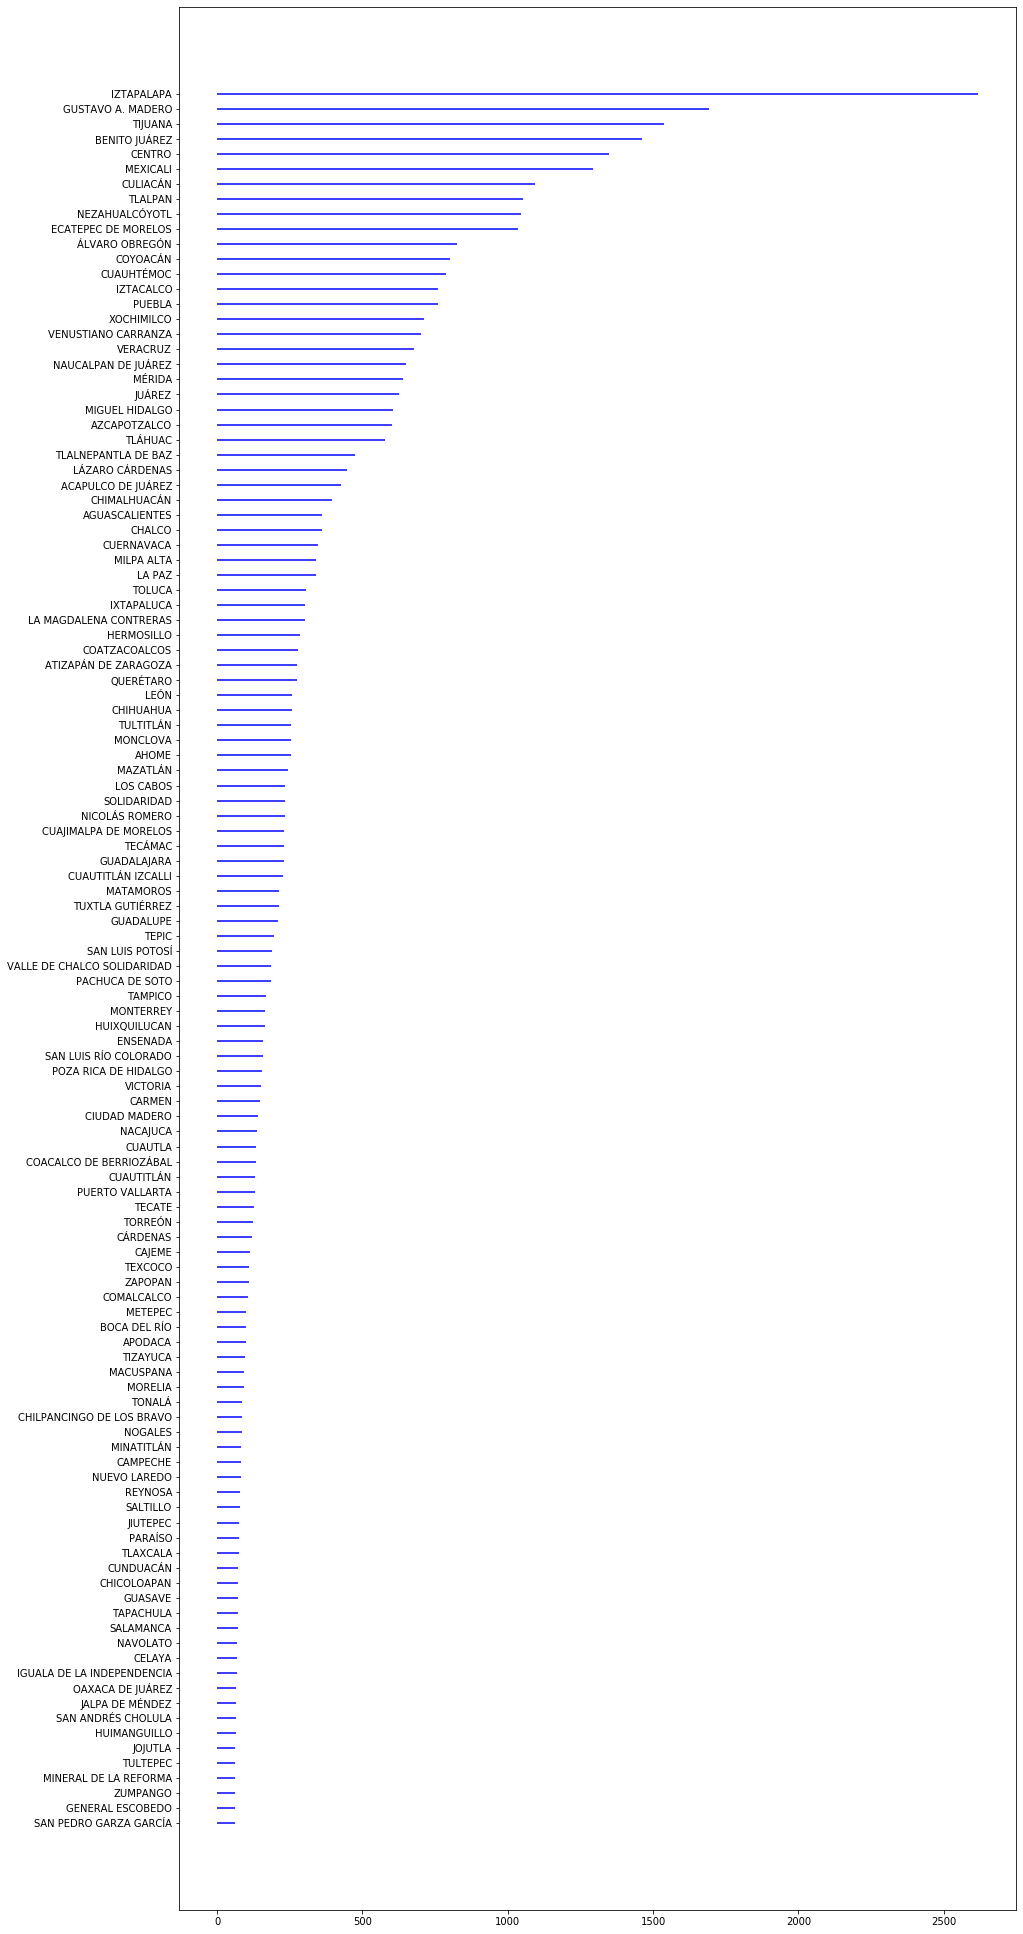

In [21]:
muni_cum=acumulados_res.loc[:,acumulados_res.columns.get_level_values(1).isin({'', "count"})]
muni_cum.columns=muni_cum.columns.droplevel()
muni_cum=muni_cum.rename(columns={"": "Municipio", "count": "Acumulados"})
muni_cum=muni_cum.sort_values("Acumulados",ascending=False)
muni_cum['count']=muni_cum['Acumulados'].astype(int)
muni_cum=muni_cum.sort_values("Acumulados")
muni_cum=muni_cum.loc[muni_cum["Acumulados"]>=60]
if (len(muni_cum)>35):
    plt.figure(figsize=(15,35)) 
else:
    plt.figure(figsize=(15,10))
plt.hlines(y='Municipio', xmin=0, xmax='Acumulados', color='blue',data=muni_cum)
plt.show()

In [22]:
nuevo=origin.groupby(origin['ENTIDAD_UM']).describe().reset_index()
nuevo

ENTIDAD_UM RESULTADO                                \
                                        count mean  std  min  25%  50%  75%   
0                    AGUASCALIENTES     447.0  1.0  0.0  1.0  1.0  1.0  1.0   
1                   BAJA CALIFORNIA    3205.0  1.0  0.0  1.0  1.0  1.0  1.0   
2               BAJA CALIFORNIA SUR     441.0  1.0  0.0  1.0  1.0  1.0  1.0   
3                          CAMPECHE     374.0  1.0  0.0  1.0  1.0  1.0  1.0   
4                           CHIAPAS     589.0  1.0  0.0  1.0  1.0  1.0  1.0   
5                         CHIHUAHUA     898.0  1.0  0.0  1.0  1.0  1.0  1.0   
6                  CIUDAD DE MÉXICO   15609.0  1.0  0.0  1.0  1.0  1.0  1.0   
7              COAHUILA DE ZARAGOZA     671.0  1.0  0.0  1.0  1.0  1.0  1.0   
8                            COLIMA      59.0  1.0  0.0  1.0  1.0  1.0  1.0   
9                           DURANGO     155.0  1.0  0.0  1.0  1.0  1.0  1.0   
10                       GUANAJUATO     692.0  1.0  0.0  1.0  1.0  1.0  1.0   
11                         GUERRERO     754.0  1.0  0.0  1.0  1.0  1.0  1.0   
12                          HIDALGO     802.0  1.0  0.0  1.0  1.0  1.0  1.0   
13                          JALISCO     802.0  1.0  0.0  1.0  1.0  1.0  1.0   
14              MICHOACÁN DE OCAMPO     883.0  1.0  0.0  1.0  1.0  1.0  1.0   
15                          MORELOS    1012.0  1.0  0.0  1.0  1.0  1.0  1.0   
16                           MÉXICO    5369.0  1.0  0.0  1.0  1.0  1.0  1.0   
17                          NAYARIT     291.0  1.0  0.0  1.0  1.0  1.0  1.0   
18                       NUEVO LEÓN     800.0  1.0  0.0  1.0  1.0  1.0  1.0   
19                           OAXACA     411.0  1.0  0.0  1.0  1.0  1.0  1.0   
20                           PUEBLA    1419.0  1.0  0.0  1.0  1.0  1.0  1.0   
21                        QUERÉTARO     421.0  1.0  0.0  1.0  1.0  1.0  1.0   
22                     QUINTANA ROO    1278.0  1.0  0.0  1.0  1.0  1.0  1.0   
23                  SAN LUIS POTOSÍ     430.0  1.0  0.0  1.0  1.0  1.0  1.0   
24                          SINALOA    1871.0  1.0  0.0  1.0  1.0  1.0  1.0   
25                           SONORA     751.0  1.0  0.0  1.0  1.0  1.0  1.0   
26                          TABASCO    2238.0  1.0  0.0  1.0  1.0  1.0  1.0   
27                       TAMAULIPAS     920.0  1.0  0.0  1.0  1.0  1.0  1.0   
28                         TLAXCALA     546.0  1.0  0.0  1.0  1.0  1.0  1.0   
29  VERACRUZ DE IGNACIO DE LA LLAVE    1747.0  1.0  0.0  1.0  1.0  1.0  1.0   
30                          YUCATÁN    1077.0  1.0  0.0  1.0  1.0  1.0  1.0   
31                        ZACATECAS     182.0  1.0  0.0  1.0  1.0  1.0  1.0   

         
    max  
0   1.0  
1   1.0  
2   1.0  
3   1.0  
4   1.0  
5   1.0  
6   1.0  
7   1.0  
8   1.0  
9   1.0  
10  1.0  
11  1.0  
12  1.0  
13  1.0  
14  1.0  
15  1.0  
16  1.0  
17  1.0  
18  1.0  
19  1.0  
20  1.0  
21  1.0  
22  1.0  
23  1.0  
24  1.0  
25  1.0  
26  1.0  
27  1.0  
28  1.0  
29  1.0  
30  1.0  
31  1.0

In [23]:
print(nuevo.columns.levels) 
print(nuevo.columns)

[['RESULTADO', 'ENTIDAD_UM'], ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', '']]
MultiIndex([('ENTIDAD_UM',      ''),
            ( 'RESULTADO', 'count'),
            ( 'RESULTADO',  'mean'),
            ( 'RESULTADO',   'std'),
            ( 'RESULTADO',   'min'),
            ( 'RESULTADO',   '25%'),
            ( 'RESULTADO',   '50%'),
            ( 'RESULTADO',   '75%'),
            ( 'RESULTADO',   'max')],
           )


Contagios totales en el país:  47144


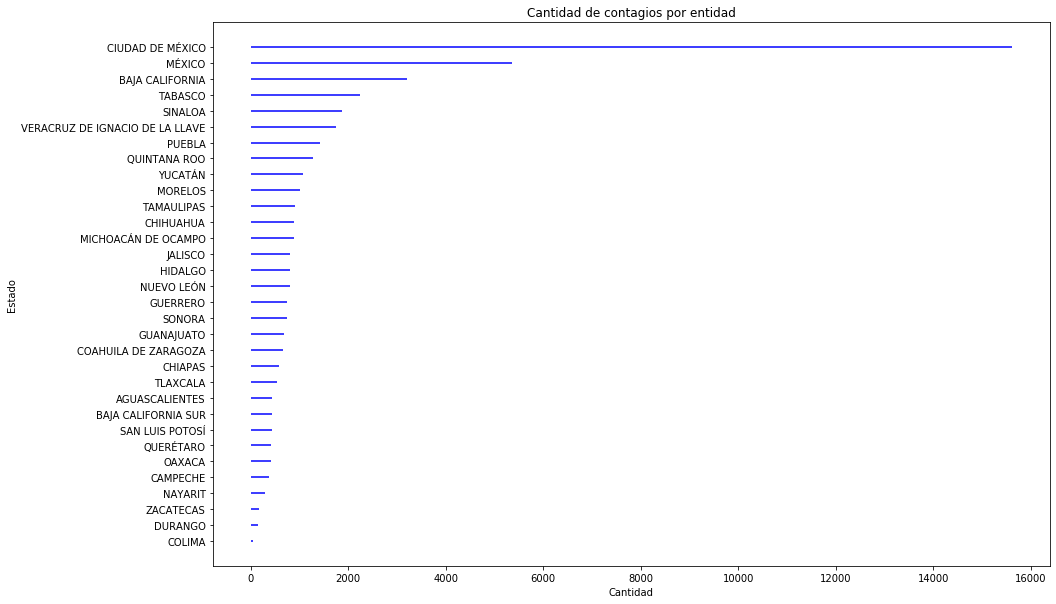

In [24]:
dada=nuevo.loc[:,nuevo.columns.get_level_values(1).isin({'', "count"})]
dada.columns=dada.columns.droplevel()
dada=dada.rename(columns={"": "Entidad", "B": "c"})
dada['count']=dada['count'].astype(int)
dada=dada.sort_values("count")
print("Contagios totales en el país: ",sum(dada['count']))
plt.figure(figsize=(15,10))
plt.hlines(y='Entidad', xmin=0, xmax='count', color='blue',data=dada)
plt.title("Cantidad de contagios por entidad")
plt.xlabel("Cantidad")
plt.ylabel("Estado")
plt.show()

In [25]:
suma=sum(dada['count'])
dada['porcentaje']=list(map(lambda x: (x*100)/suma, dada['count']))
dada.sort_values('porcentaje',ascending=False)

Entidad  count  porcentaje
6                  CIUDAD DE MÉXICO  15609   33.109197
16                           MÉXICO   5369   11.388512
1                   BAJA CALIFORNIA   3205    6.798320
26                          TABASCO   2238    4.747158
24                          SINALOA   1871    3.968692
29  VERACRUZ DE IGNACIO DE LA LLAVE   1747    3.705668
20                           PUEBLA   1419    3.009927
22                     QUINTANA ROO   1278    2.710843
30                          YUCATÁN   1077    2.284490
15                          MORELOS   1012    2.146615
27                       TAMAULIPAS    920    1.951468
5                         CHIHUAHUA    898    1.904802
14              MICHOACÁN DE OCAMPO    883    1.872985
12                          HIDALGO    802    1.701171
13                          JALISCO    802    1.701171
18                       NUEVO LEÓN    800    1.696929
11                         GUERRERO    754    1.599355
25                           SONORA    751    1.592992
10                       GUANAJUATO    692    1.467843
7              COAHUILA DE ZARAGOZA    671    1.423299
4                           CHIAPAS    589    1.249364
28                         TLAXCALA    546    1.158154
0                    AGUASCALIENTES    447    0.948159
2               BAJA CALIFORNIA SUR    441    0.935432
23                  SAN LUIS POTOSÍ    430    0.912099
21                        QUERÉTARO    421    0.893009
19                           OAXACA    411    0.871797
3                          CAMPECHE    374    0.793314
17                          NAYARIT    291    0.617258
31                        ZACATECAS    182    0.386051
9                           DURANGO    155    0.328780
8                            COLIMA     59    0.125148

## Acumulados fecha Entidad y municipios

In [26]:
w=dada.sort_values('count',ascending=False)
el=[]
for i in w['Entidad']:
    el.append(i)
print(el)

['CIUDAD DE MÉXICO', 'MÉXICO', 'BAJA CALIFORNIA', 'TABASCO', 'SINALOA', 'VERACRUZ DE IGNACIO DE LA LLAVE', 'PUEBLA', 'QUINTANA ROO', 'YUCATÁN', 'MORELOS', 'TAMAULIPAS', 'CHIHUAHUA', 'MICHOACÁN DE OCAMPO', 'HIDALGO', 'JALISCO', 'NUEVO LEÓN', 'GUERRERO', 'SONORA', 'GUANAJUATO', 'COAHUILA DE ZARAGOZA', 'CHIAPAS', 'TLAXCALA', 'AGUASCALIENTES', 'BAJA CALIFORNIA SUR', 'SAN LUIS POTOSÍ', 'QUERÉTARO', 'OAXACA', 'CAMPECHE', 'NAYARIT', 'ZACATECAS', 'DURANGO', 'COLIMA']


In [27]:
grupito=origin.groupby(['FECHA_INGRESO', 'ENTIDAD_RES']).describe().reset_index()

In [28]:
grp=grupito.loc[:,grupito.columns.get_level_values(1).isin({'', "count"})]
grp.columns=grp.columns.droplevel()

In [29]:
grp.columns=['Fecha','Entidad','conteo']
grupito=grp.groupby('Entidad')
grupito.groups.keys()

dict_keys(['AGUASCALIENTES', 'BAJA CALIFORNIA', 'BAJA CALIFORNIA SUR', 'CAMPECHE', 'CHIAPAS', 'CHIHUAHUA', 'CIUDAD DE MÉXICO', 'COAHUILA DE ZARAGOZA', 'COLIMA', 'DURANGO', 'GUANAJUATO', 'GUERRERO', 'HIDALGO', 'JALISCO', 'MICHOACÁN DE OCAMPO', 'MORELOS', 'MÉXICO', 'NAYARIT', 'NUEVO LEÓN', 'OAXACA', 'PUEBLA', 'QUERÉTARO', 'QUINTANA ROO', 'SAN LUIS POTOSÍ', 'SINALOA', 'SONORA', 'TABASCO', 'TAMAULIPAS', 'TLAXCALA', 'VERACRUZ DE IGNACIO DE LA LLAVE', 'YUCATÁN', 'ZACATECAS'])

In [30]:
aleatorio=np.random.randint(1,156,32)
colores=[]
colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
for i in colors.keys():
    colores.append(i)
colores=np.random.choice(colores, 32, replace=False)

Que entidad buscas?HIDALGO


C:\Users\dell7559\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



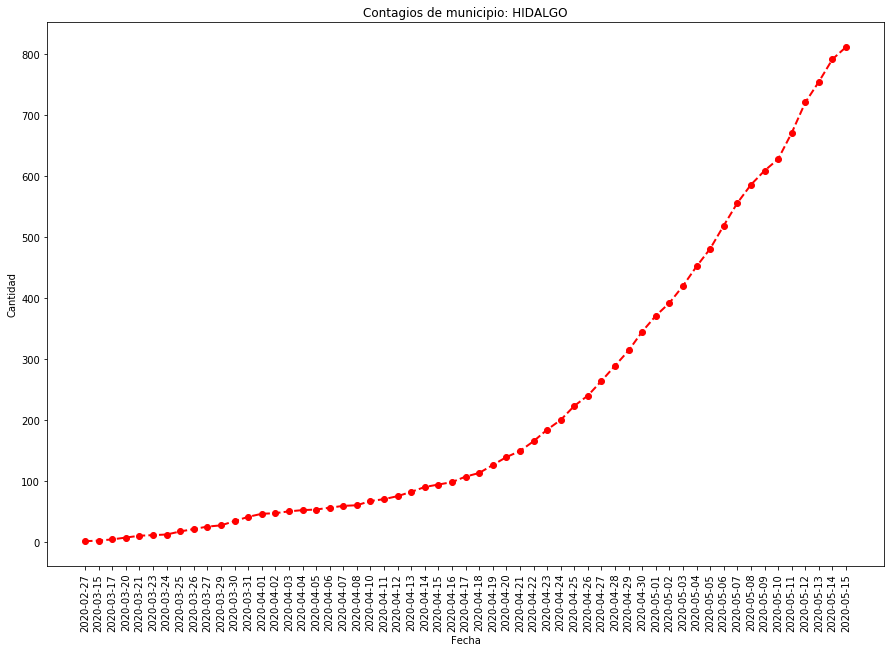

In [34]:
ciudad=input("Que entidad buscas?")
tmp=grupito.get_group(ciudad)
tmp2=tmp.copy()
tmp['Acumulados']=tmp['conteo'].cumsum()
#print(tmp)
plt.figure(figsize=(15,10))
plt.plot( 'Fecha', 'Acumulados', data=tmp, color="red", linestyle='dashed',marker='o', linewidth=2)
plt.xticks(rotation = 90)
plt.title("Contagios de municipio: "+ciudad )
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.show()

In [44]:
tmp2=origin.copy()
tmpH=tmp2.loc[tmp2["ENTIDAD_RES"]== "HIDALGO"]
tmpH=tmpH[["ENTIDAD_RES","FECHA_INGRESO"]]
tmpH=tmpH.reset_index().drop('index',axis=1)
tmpH.to_csv("D:/UNAD/carrera/Estadistica basica/unidad 3/hidalgosingroup.csv")

In [32]:
tmp

Fecha  Entidad  conteo  Acumulados
7     2020-02-27  HIDALGO     1.0         1.0
71    2020-03-15  HIDALGO     1.0         2.0
101   2020-03-17  HIDALGO     2.0         4.0
164   2020-03-20  HIDALGO     3.0         7.0
189   2020-03-21  HIDALGO     3.0        10.0
229   2020-03-23  HIDALGO     1.0        11.0
256   2020-03-24  HIDALGO     1.0        12.0
283   2020-03-25  HIDALGO     5.0        17.0
305   2020-03-26  HIDALGO     4.0        21.0
329   2020-03-27  HIDALGO     4.0        25.0
381   2020-03-29  HIDALGO     2.0        27.0
408   2020-03-30  HIDALGO     7.0        34.0
436   2020-03-31  HIDALGO     7.0        41.0
463   2020-04-01  HIDALGO     5.0        46.0
488   2020-04-02  HIDALGO     1.0        47.0
514   2020-04-03  HIDALGO     3.0        50.0
539   2020-04-04  HIDALGO     2.0        52.0
569   2020-04-05  HIDALGO     1.0        53.0
599   2020-04-06  HIDALGO     3.0        56.0
628   2020-04-07  HIDALGO     3.0        59.0
655   2020-04-08  HIDALGO     1.0        60.0
713   2020-04-10  HIDALGO     7.0        67.0
743   2020-04-11  HIDALGO     3.0        70.0
773   2020-04-12  HIDALGO     5.0        75.0
802   2020-04-13  HIDALGO     7.0        82.0
831   2020-04-14  HIDALGO     8.0        90.0
863   2020-04-15  HIDALGO     4.0        94.0
895   2020-04-16  HIDALGO     4.0        98.0
926   2020-04-17  HIDALGO     9.0       107.0
958   2020-04-18  HIDALGO     6.0       113.0
990   2020-04-19  HIDALGO    13.0       126.0
1021  2020-04-20  HIDALGO    13.0       139.0
1053  2020-04-21  HIDALGO    10.0       149.0
1085  2020-04-22  HIDALGO    16.0       165.0
1117  2020-04-23  HIDALGO    19.0       184.0
1149  2020-04-24  HIDALGO    16.0       200.0
1181  2020-04-25  HIDALGO    23.0       223.0
1211  2020-04-26  HIDALGO    17.0       240.0
1243  2020-04-27  HIDALGO    24.0       264.0
1274  2020-04-28  HIDALGO    25.0       289.0
1305  2020-04-29  HIDALGO    25.0       314.0
1337  2020-04-30  HIDALGO    31.0       345.0
1369  2020-05-01  HIDALGO    26.0       371.0
1400  2020-05-02  HIDALGO    21.0       392.0
1432  2020-05-03  HIDALGO    28.0       420.0
1464  2020-05-04  HIDALGO    32.0       452.0
1496  2020-05-05  HIDALGO    29.0       481.0
1528  2020-05-06  HIDALGO    38.0       519.0
1560  2020-05-07  HIDALGO    37.0       556.0
1592  2020-05-08  HIDALGO    30.0       586.0
1623  2020-05-09  HIDALGO    23.0       609.0
1655  2020-05-10  HIDALGO    19.0       628.0
1687  2020-05-11  HIDALGO    43.0       671.0
1719  2020-05-12  HIDALGO    50.0       721.0
1751  2020-05-13  HIDALGO    34.0       755.0
1780  2020-05-14  HIDALGO    37.0       792.0
1806  2020-05-15  HIDALGO    20.0       812.0

In [33]:
#tmp22=tmp.drop('conteo',axis=1)
tmp23=pd.DataFrame(tmp)
tmp23.to_excel("Hidalgo.xlsx")

In [53]:
niidea=[]
plots=[]
for i in grupito.groups.keys():
    tmp2=grupito.get_group(i)
    tmp2['Acumulados']=tmp2['conteo'].cumsum()
    niidea.append(tmp2)
b=pd.concat(niidea)
b
    #plt.figure(figsize=(15,10))
    #plots.append(plt.plot( 'Fecha', 'Acumulados', data=tmp, color="red", linestyle='dashed',marker='o', linewidth=2))
    #plt.xticks(rotation = 90)
    #plt.show()

C:\Users\dell7559\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Fecha         Entidad  conteo  Acumulados
1     2020-01-14  AGUASCALIENTES     1.0         1.0
56    2020-03-14  AGUASCALIENTES     1.0         2.0
95    2020-03-17  AGUASCALIENTES     1.0         3.0
114   2020-03-18  AGUASCALIENTES     3.0         6.0
136   2020-03-19  AGUASCALIENTES     1.0         7.0
...          ...             ...     ...         ...
1706  2020-05-11       ZACATECAS     9.0       171.0
1738  2020-05-12       ZACATECAS     3.0       174.0
1770  2020-05-13       ZACATECAS     7.0       181.0
1798  2020-05-14       ZACATECAS     8.0       189.0
1819  2020-05-15       ZACATECAS     1.0       190.0

[1820 rows x 4 columns]

In [54]:
b=b.sort_values('Fecha')

In [55]:
c=b.groupby('Entidad')
c.get_group('AGUASCALIENTES')

Fecha         Entidad  conteo  Acumulados
1     2020-01-14  AGUASCALIENTES     1.0         1.0
56    2020-03-14  AGUASCALIENTES     1.0         2.0
95    2020-03-17  AGUASCALIENTES     1.0         3.0
114   2020-03-18  AGUASCALIENTES     3.0         6.0
136   2020-03-19  AGUASCALIENTES     1.0         7.0
157   2020-03-20  AGUASCALIENTES     2.0         9.0
181   2020-03-21  AGUASCALIENTES     1.0        10.0
203   2020-03-22  AGUASCALIENTES     1.0        11.0
219   2020-03-23  AGUASCALIENTES     4.0        15.0
275   2020-03-25  AGUASCALIENTES    17.0        32.0
296   2020-03-26  AGUASCALIENTES     3.0        35.0
319   2020-03-27  AGUASCALIENTES     6.0        41.0
347   2020-03-28  AGUASCALIENTES     5.0        46.0
372   2020-03-29  AGUASCALIENTES     3.0        49.0
397   2020-03-30  AGUASCALIENTES     4.0        53.0
425   2020-03-31  AGUASCALIENTES     1.0        54.0
504   2020-04-03  AGUASCALIENTES     2.0        56.0
559   2020-04-05  AGUASCALIENTES     3.0        59.0
588   2020-04-06  AGUASCALIENTES     4.0        63.0
619   2020-04-07  AGUASCALIENTES     1.0        64.0
646   2020-04-08  AGUASCALIENTES     1.0        65.0
703   2020-04-10  AGUASCALIENTES     2.0        67.0
731   2020-04-11  AGUASCALIENTES     1.0        68.0
763   2020-04-12  AGUASCALIENTES     2.0        70.0
792   2020-04-13  AGUASCALIENTES     6.0        76.0
821   2020-04-14  AGUASCALIENTES     2.0        78.0
851   2020-04-15  AGUASCALIENTES    11.0        89.0
883   2020-04-16  AGUASCALIENTES     6.0        95.0
915   2020-04-17  AGUASCALIENTES    15.0       110.0
946   2020-04-18  AGUASCALIENTES    12.0       122.0
978   2020-04-19  AGUASCALIENTES     3.0       125.0
1009  2020-04-20  AGUASCALIENTES    15.0       140.0
1041  2020-04-21  AGUASCALIENTES    13.0       153.0
1073  2020-04-22  AGUASCALIENTES    11.0       164.0
1105  2020-04-23  AGUASCALIENTES    20.0       184.0
1137  2020-04-24  AGUASCALIENTES    11.0       195.0
1169  2020-04-25  AGUASCALIENTES     1.0       196.0
1200  2020-04-26  AGUASCALIENTES     7.0       203.0
1231  2020-04-27  AGUASCALIENTES    15.0       218.0
1263  2020-04-28  AGUASCALIENTES    26.0       244.0
1294  2020-04-29  AGUASCALIENTES    17.0       261.0
1325  2020-04-30  AGUASCALIENTES    23.0       284.0
1357  2020-05-01  AGUASCALIENTES     4.0       288.0
1389  2020-05-02  AGUASCALIENTES     2.0       290.0
1420  2020-05-03  AGUASCALIENTES     2.0       292.0
1452  2020-05-04  AGUASCALIENTES    44.0       336.0
1484  2020-05-05  AGUASCALIENTES     9.0       345.0
1516  2020-05-06  AGUASCALIENTES    15.0       360.0
1548  2020-05-07  AGUASCALIENTES    20.0       380.0
1580  2020-05-08  AGUASCALIENTES    12.0       392.0
1643  2020-05-10  AGUASCALIENTES     4.0       396.0
1675  2020-05-11  AGUASCALIENTES    11.0       407.0
1707  2020-05-12  AGUASCALIENTES    26.0       433.0
1739  2020-05-13  AGUASCALIENTES     7.0       440.0
1799  2020-05-15  AGUASCALIENTES     2.0       442.0

In [56]:
grupito.groups

{'AGUASCALIENTES': Int64Index([   1,   56,   95,  114,  136,  157,  181,  203,  219,  275,  296,
              319,  347,  372,  397,  425,  504,  559,  588,  619,  646,  703,
              731,  763,  792,  821,  851,  883,  915,  946,  978, 1009, 1041,
             1073, 1105, 1137, 1169, 1200, 1231, 1263, 1294, 1325, 1357, 1389,
             1420, 1452, 1484, 1516, 1548, 1580, 1643, 1675, 1707, 1739, 1799],
            dtype='int64'),
 'BAJA CALIFORNIA': Int64Index([  25,   79,   96,  115,  137,  158,  182,  204,  220,  248,  276,
              297,  320,  348,  373,  398,  426,  453,  479,  505,  531,  560,
              589,  620,  647,  675,  704,  732,  764,  793,  822,  852,  884,
              916,  947,  979, 1010, 1042, 1074, 1106, 1138, 1170, 1201, 1232,
             1264, 1295, 1326, 1358, 1390, 1421, 1453, 1485, 1517, 1549, 1581,
             1612, 1644, 1676, 1708, 1740, 1771, 1800],
            dtype='int64'),
 'BAJA CALIFORNIA SUR': Int64Index([ 116,  159,  183,  221, 

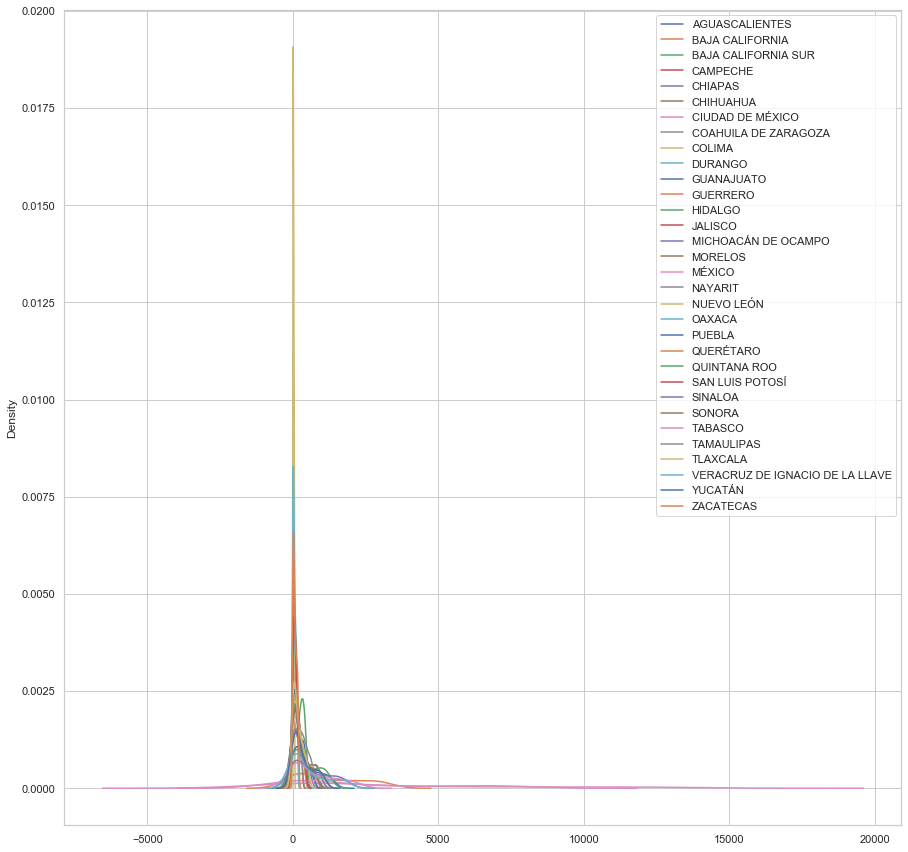

In [57]:
#fig1, ax1 = plt.subplots()
#plt.figure(figsize=(15,15))
#plt.plot('Fecha','Acumulados',data=tmp2,color='green')
#plt.xticks(rotation = 90)
#plt.legend(ncol=4, loc='best')

fig, ax = plt.subplots(figsize=(8,4))
for label, df in b.groupby('Entidad'):
    df.Acumulados.plot(kind="kde", ax=ax, label=label,figsize=(15,15))
plt.legend()

In [58]:
b=pd.concat(niidea)
b.reset_index()
b

Fecha         Entidad  conteo  Acumulados
1     2020-01-14  AGUASCALIENTES     1.0         1.0
56    2020-03-14  AGUASCALIENTES     1.0         2.0
95    2020-03-17  AGUASCALIENTES     1.0         3.0
114   2020-03-18  AGUASCALIENTES     3.0         6.0
136   2020-03-19  AGUASCALIENTES     1.0         7.0
...          ...             ...     ...         ...
1706  2020-05-11       ZACATECAS     9.0       171.0
1738  2020-05-12       ZACATECAS     3.0       174.0
1770  2020-05-13       ZACATECAS     7.0       181.0
1798  2020-05-14       ZACATECAS     8.0       189.0
1819  2020-05-15       ZACATECAS     1.0       190.0

[1820 rows x 4 columns]

In [59]:
wx=b.copy()
#wx=wx.drop(['index'],axis=1)
#d_max = datetime.strptime(d_max, '%Y-%m-%d').date()
#d_min = datetime.strptime(d_min, '%Y-%m-%d').date()
#rangedate=list(pd.date_range(d_min-timedelta(days=1),d_max+timedelta(days=1),freq='d'))
wx['Fecha']=list(map(lambda x: datetime.strptime(x,'%Y-%m-%d').date(), wx['Fecha']))
#rangedate
#for i in wx['Fecha']:
#    print(type(i))
wx

Fecha         Entidad  conteo  Acumulados
1     2020-01-14  AGUASCALIENTES     1.0         1.0
56    2020-03-14  AGUASCALIENTES     1.0         2.0
95    2020-03-17  AGUASCALIENTES     1.0         3.0
114   2020-03-18  AGUASCALIENTES     3.0         6.0
136   2020-03-19  AGUASCALIENTES     1.0         7.0
...          ...             ...     ...         ...
1706  2020-05-11       ZACATECAS     9.0       171.0
1738  2020-05-12       ZACATECAS     3.0       174.0
1770  2020-05-13       ZACATECAS     7.0       181.0
1798  2020-05-14       ZACATECAS     8.0       189.0
1819  2020-05-15       ZACATECAS     1.0       190.0

[1820 rows x 4 columns]

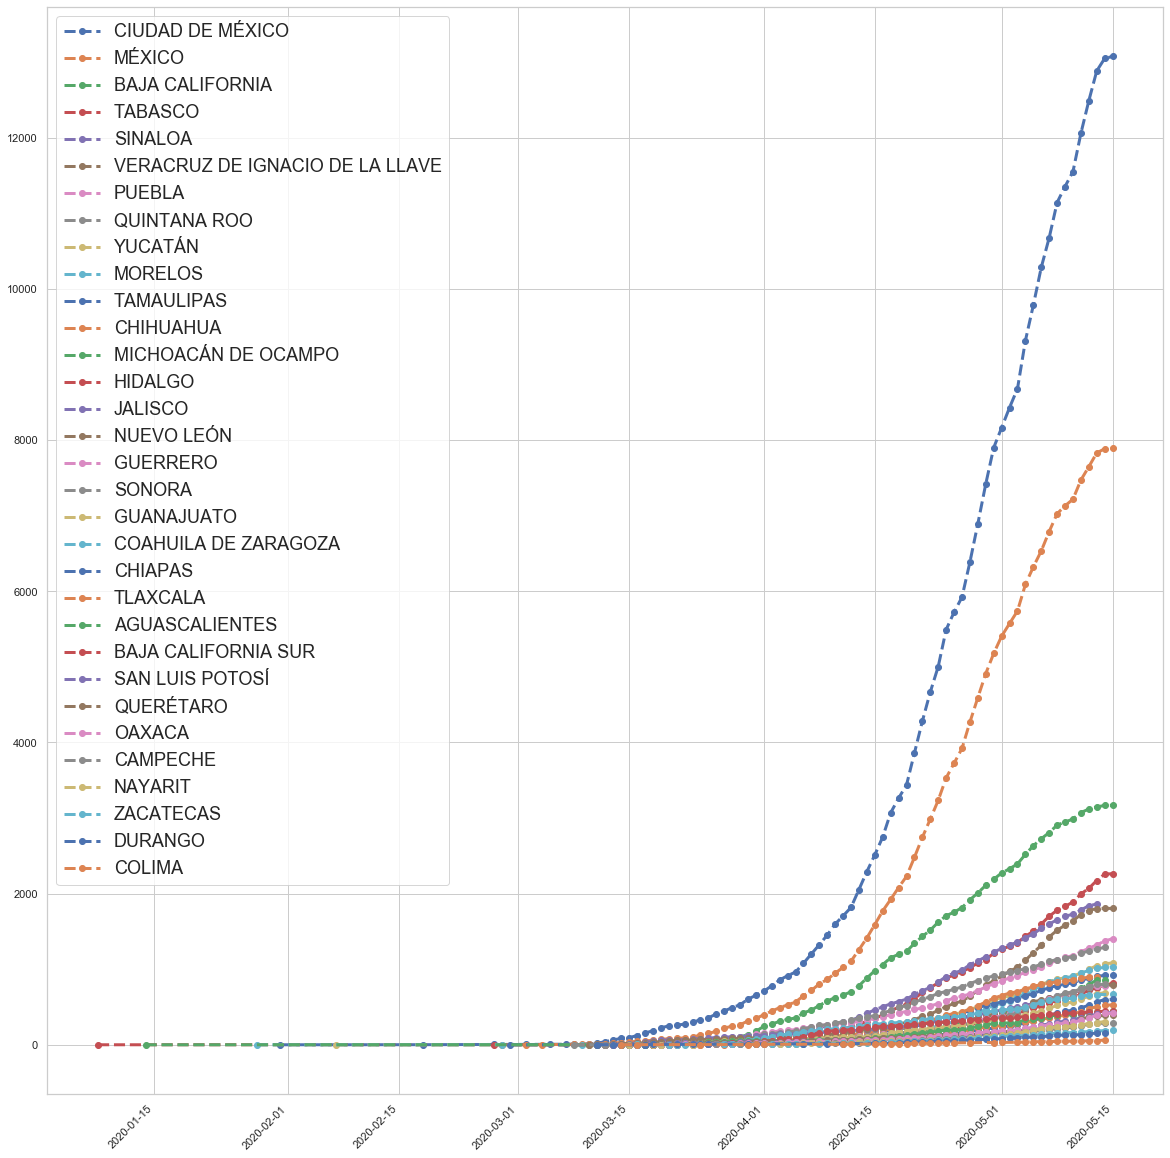

In [61]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot()
for label in el:
    #ax.plot(b['Fecha'][i], b['Acumulados'][i])
    entity=wx.loc[wx['Entidad']==label]
    ax.plot('Fecha','Acumulados', data=entity, label=label,linestyle='dashed',marker='o', linewidth=3)
    #ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical', horizontalalignment='right')

#ax.set_xlabel('Time (s)')
#ax.set_ylabel('Scale (Bananas)')

#ax.set_xticklabels(labels=label,rotation=90)
#ax.legend(fontsize=18)
plt.xticks(rotation=45,
        horizontalalignment="right")
plt.legend(fontsize=18)
#plt.savefig('bien.jpg',metadata=METADATA)
plt.show()

In [62]:
from datetime import date, timedelta
d_max=max(list(b['Fecha']))
d_min=min(list(b['Fecha']))
d_max = datetime.strptime(d_max, '%Y-%m-%d').date()
d_min = datetime.strptime(d_min, '%Y-%m-%d').date()
rangedate=list(pd.date_range(d_min-timedelta(days=1),d_max+timedelta(days=1),freq='d'))
rangedate=list(map(lambda x: x.strftime('%Y-%m-%d'), rangedate))
rangedate

['2020-01-07',
 '2020-01-08',
 '2020-01-09',
 '2020-01-10',
 '2020-01-11',
 '2020-01-12',
 '2020-01-13',
 '2020-01-14',
 '2020-01-15',
 '2020-01-16',
 '2020-01-17',
 '2020-01-18',
 '2020-01-19',
 '2020-01-20',
 '2020-01-21',
 '2020-01-22',
 '2020-01-23',
 '2020-01-24',
 '2020-01-25',
 '2020-01-26',
 '2020-01-27',
 '2020-01-28',
 '2020-01-29',
 '2020-01-30',
 '2020-01-31',
 '2020-02-01',
 '2020-02-02',
 '2020-02-03',
 '2020-02-04',
 '2020-02-05',
 '2020-02-06',
 '2020-02-07',
 '2020-02-08',
 '2020-02-09',
 '2020-02-10',
 '2020-02-11',
 '2020-02-12',
 '2020-02-13',
 '2020-02-14',
 '2020-02-15',
 '2020-02-16',
 '2020-02-17',
 '2020-02-18',
 '2020-02-19',
 '2020-02-20',
 '2020-02-21',
 '2020-02-22',
 '2020-02-23',
 '2020-02-24',
 '2020-02-25',
 '2020-02-26',
 '2020-02-27',
 '2020-02-28',
 '2020-02-29',
 '2020-03-01',
 '2020-03-02',
 '2020-03-03',
 '2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-07',
 '2020-03-08',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-

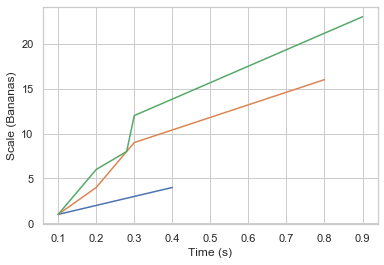

In [63]:
x_data = [[0.1, 0.2, 0.3, 0.4],[0.1, 0.2, 0.3, 0.8],[0.1, 0.2,0.28, 0.3, 0.9]]
y_data = [[1, 2, 3, 4],[1, 4, 9, 16],[1,6,8,12,23]]

fig = plt.figure()
ax = fig.add_subplot()
for i in range(len(x_data)):
    ax.plot(x_data[i], y_data[i])

ax.set_xlabel('Time (s)')
ax.set_ylabel('Scale (Bananas)')

plt.show()

In [64]:
b['Entidad']
#sorted(set(w), key=w.index)

1       AGUASCALIENTES
56      AGUASCALIENTES
95      AGUASCALIENTES
114     AGUASCALIENTES
136     AGUASCALIENTES
             ...      
1706         ZACATECAS
1738         ZACATECAS
1770         ZACATECAS
1798         ZACATECAS
1819         ZACATECAS
Name: Entidad, Length: 1820, dtype: object

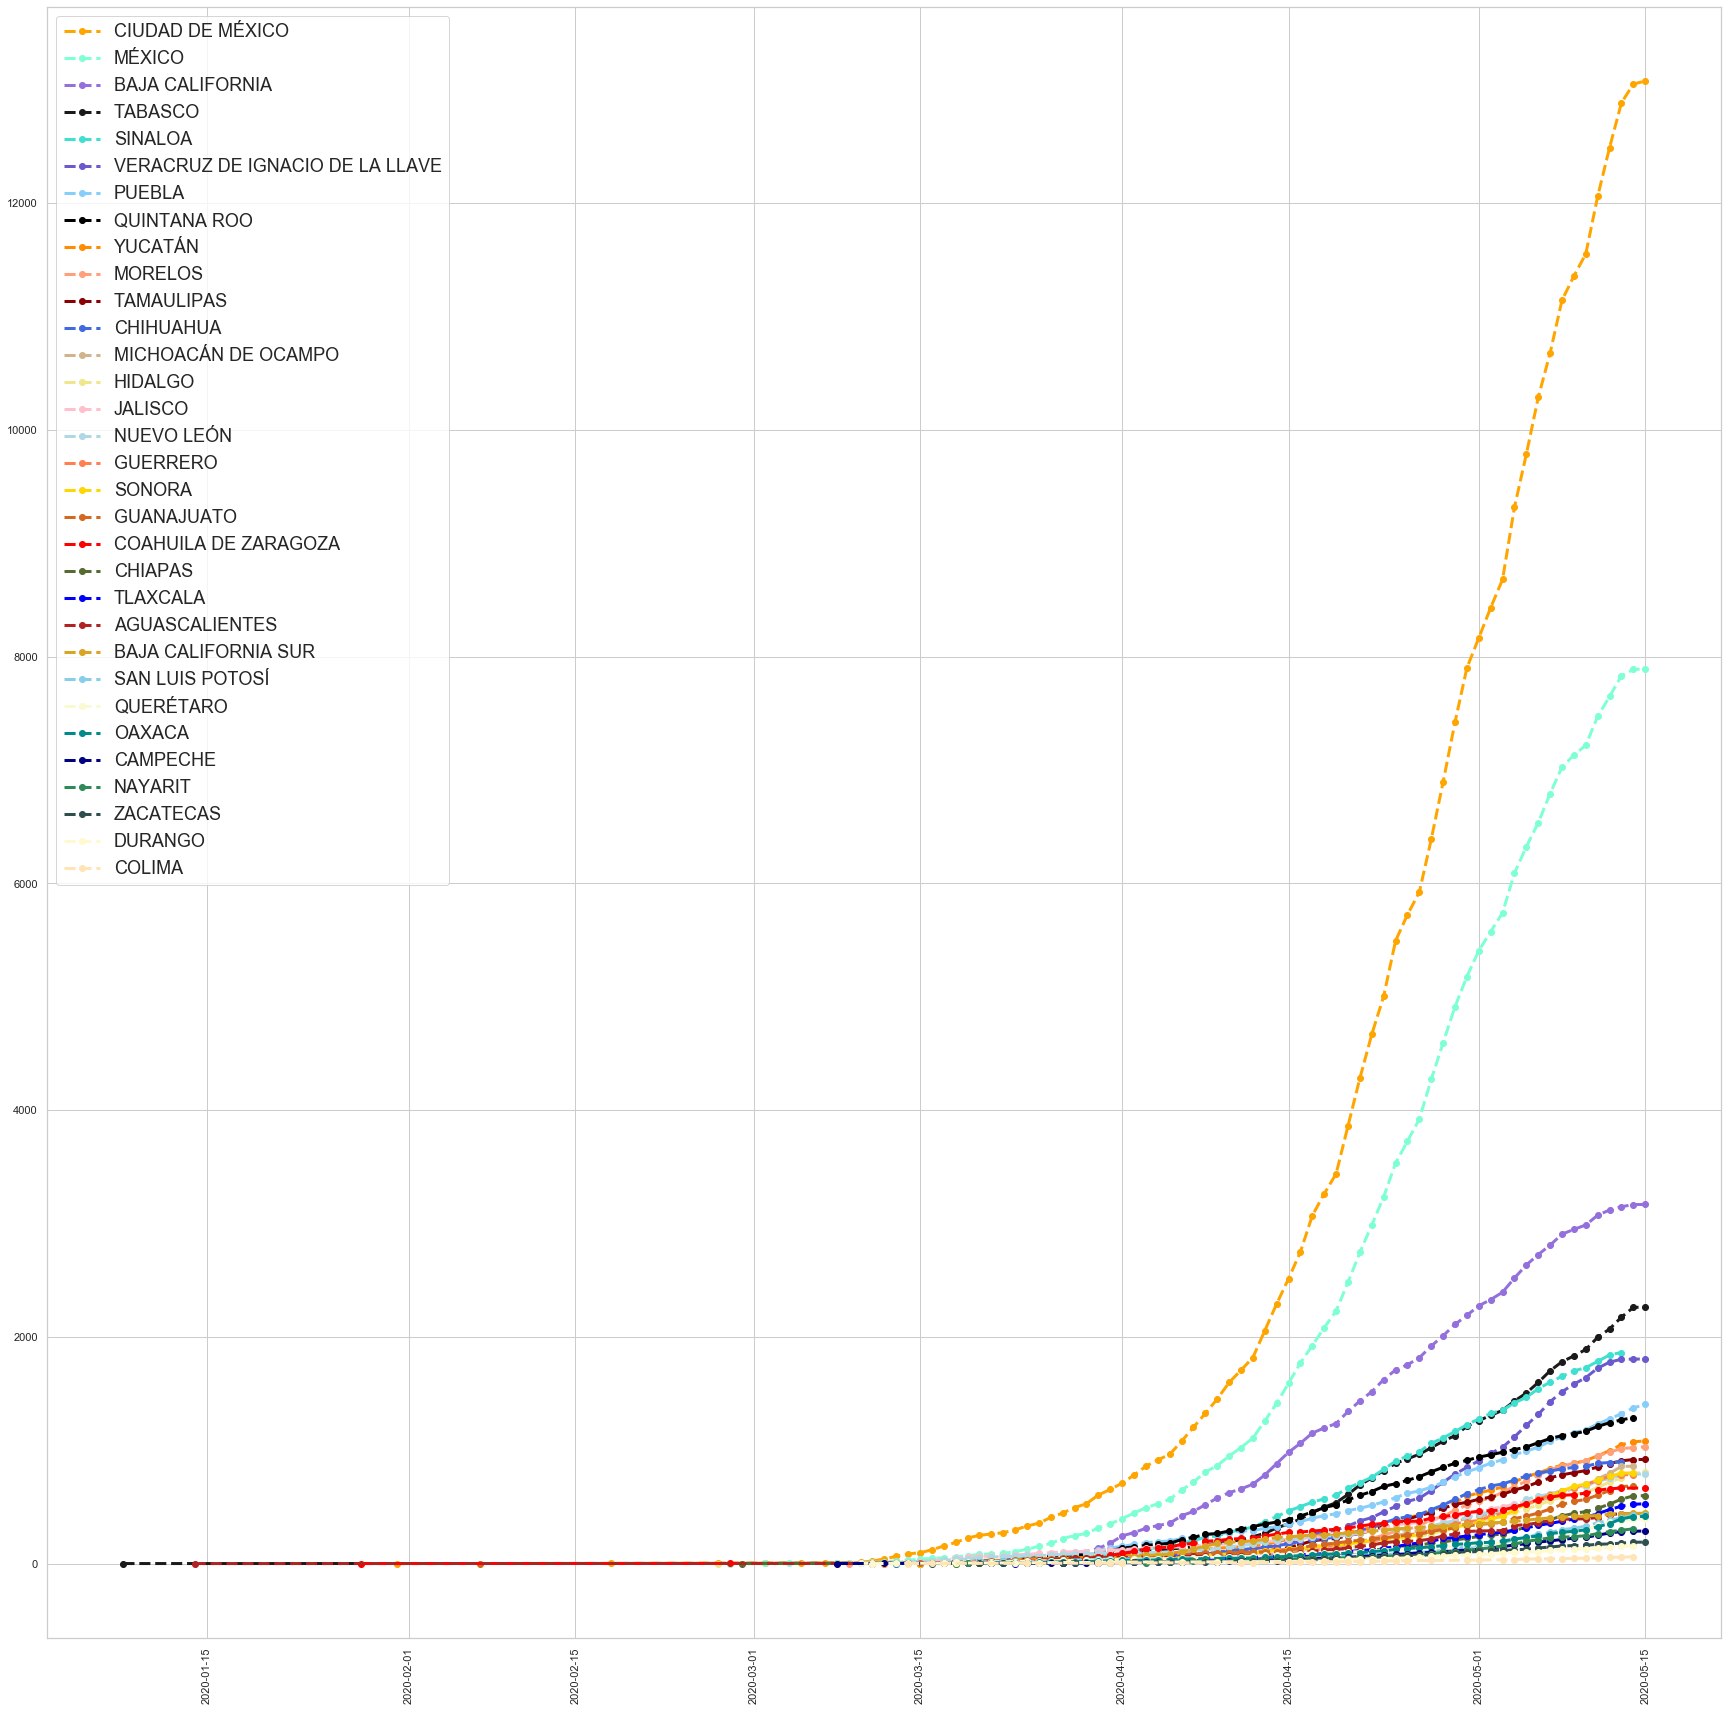

In [65]:
METADATA = {"version":"1.0", "OP":"ihuston"}
plt.figure(figsize=(30,30))
z=0
for label in el:
    #print(label)
    entity=wx.loc[wx['Entidad']==label]
    plt.plot('Fecha','Acumulados', data=entity, color=colores[z], label=label,linestyle='dashed',marker='o', linewidth=3)
    z+=1
    #df.Acumulados.plot(kind="kde", ax=ax, label=label,figsize=(15,15))
plt.xticks(rotation=90)
plt.legend(fontsize=18)
plt.savefig('extraño.jpg',metadata=METADATA)

## Mapeo

In [66]:
coordinadas=pd.read_csv('AGEEML_2020420123856.csv')

C:\Users\dell7559\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.



In [67]:
coordinadas.loc[(coordinadas['Nom_Ent']=='Chihuahua')&(coordinadas['Nom_Mun']=='Juárez')]

Mapa  Cve_Ent    Nom_Ent Nom_Abr  Cve_Mun Nom_Mun  Cve_Loc  \
74714  80370001        8  Chihuahua   Chih.       37  Juárez        1   
74715  80370009        8  Chihuahua   Chih.       37  Juárez        9   
74716  80370600        8  Chihuahua   Chih.       37  Juárez      600   
74717  80370612        8  Chihuahua   Chih.       37  Juárez      612   
74718  80370613        8  Chihuahua   Chih.       37  Juárez      613   
...         ...      ...        ...     ...      ...     ...      ...   
74991  80371191        8  Chihuahua   Chih.       37  Juárez     1191   
74992  80371192        8  Chihuahua   Chih.       37  Juárez     1192   
74993  80371193        8  Chihuahua   Chih.       37  Juárez     1193   
74994  80371194        8  Chihuahua   Chih.       37  Juárez     1194   
74995  80371195        8  Chihuahua   Chih.       37  Juárez     1195   

                  Nom_Loc Ámbito         Latitud         Longitud  \
74714              Juárez      U  31°44´47.275N"  106°29´06.067W"   
74715       Gloria a Dios      R  31°25´37.626N"  106°25´41.701W"   
74716    Cerros Colorados      R  31°10´40.322N"  106°20´58.232W"   
74717           El Jonuco      R  31°11´45.066N"  106°40´14.498W"   
74718         Loma Blanca      R  31°34´55.094N"  106°17´48.434W"   
...                   ...    ...             ...              ...   
74991         Willy Prado      R  31°22´09.738N"  106°26´20.598W"   
74992              Coyote      R  31°21´02.457N"  106°27´16.308W"   
74993  Rancho de la Torre      R  31°32´05.377N"  106°16´15.964W"   
74994      Manuel Morales      R  31°28´51.198N"  106°13´40.414W"   
74995        María Mercel      R  31°27´48.800N"  106°12´43.038W"   

       Lat_Decimal  Lon_Decimal Altitud Cve_Carta Pob_Total Pob_Masculina  \
74714    31.746465  -106.485019    1131    H13A25   1321004        659857   
74715    31.427118  -106.428250    1289    H13A35         0             0   
74716    31.177867  -106.349509    1396    H13A45         0             0   
74717    31.195852  -106.670694    1210    H13A44         0             0   
74718    31.581971  -106.296787    1116    H13A26      2169          1084   
...            ...          ...     ...       ...       ...           ...   
74991    31.369372  -106.439055    1271    H13A35         -             -   
74992    31.350683  -106.454530    1275    H13A35         -             -   
74993    31.534827  -106.271101    1121    H13A26         -             -   
74994    31.480888  -106.227893    1101    H13A36         -             -   
74995    31.463556  -106.211955    1100    H13A36         -             -   

      Pob_Femenina Total De Viviendas Habitadas  
74714       661147                       361370  
74715            0                            0  
74716            0                            0  
74717            0                            0  
74718         1085                          723  
...            ...                          ...  
74991            -                            -  
74992            -                            -  
74993            -                            -  
74994            -                            -  
74995            -                            -  

[282 rows x 19 columns]

In [68]:
coordinadas.head()

Mapa  Cve_Ent         Nom_Ent Nom_Abr  Cve_Mun         Nom_Mun  \
0  10010001        1  Aguascalientes    Ags.        1  Aguascalientes   
1  10010094        1  Aguascalientes    Ags.        1  Aguascalientes   
2  10010096        1  Aguascalientes    Ags.        1  Aguascalientes   
3  10010100        1  Aguascalientes    Ags.        1  Aguascalientes   
4  10010102        1  Aguascalientes    Ags.        1  Aguascalientes   

   Cve_Loc                 Nom_Loc Ámbito         Latitud         Longitud  \
0        1          Aguascalientes      U  21°52´47.362N"  102°17´45.768W"   
1       94          Granja Adelita      R  21°52´18.749N"  102°22´24.710W"   
2       96               Agua Azul      R  21°53´01.522N"  102°21´25.639W"   
3      100           Rancho Alegre      R  21°51´16.556N"  102°22´21.884W"   
4      102  Los Arbolitos [Rancho]      R  21°46´48.650N"  102°21´26.261W"   

   Lat_Decimal  Lon_Decimal Altitud Cve_Carta Pob_Total Pob_Masculina  \
0    21.879823  -102.296047    1878    F13D19    722250        348722   
1    21.871875  -102.373531    1902    F13D18        14             *   
2    21.883756  -102.357122    1861    F13D18        37            21   
3    21.854599  -102.372746    1879    F13D18        10             *   
4    21.780181  -102.357295    1861    F13D18         7             *   

  Pob_Femenina Total De Viviendas Habitadas  
0       373528                       185120  
1            *                            2  
2           16                           11  
3            *                            1  
4            *                            1

In [69]:
copia_origen=origin.copy()

In [70]:
copia_origen=copia_origen.reset_index()

In [71]:
copia_origen

index      ENTIDAD_UM     ENTIDAD_NAC     ENTIDAD_RES   MUNICIPIO_RES  \
0         90  AGUASCALIENTES        CAMPECHE  AGUASCALIENTES     JESÚS MARÍA   
1        181  AGUASCALIENTES          MÉXICO  AGUASCALIENTES  AGUASCALIENTES   
2        342  AGUASCALIENTES  AGUASCALIENTES  AGUASCALIENTES  AGUASCALIENTES   
3        443  AGUASCALIENTES  AGUASCALIENTES  AGUASCALIENTES     JESÚS MARÍA   
4        486  AGUASCALIENTES       ZACATECAS  AGUASCALIENTES  AGUASCALIENTES   
...      ...             ...             ...             ...             ...   
47139  46143       ZACATECAS       ZACATECAS       ZACATECAS           JEREZ   
47140  46338       ZACATECAS       ZACATECAS       ZACATECAS       TEPETONGO   
47141  46689       ZACATECAS       ZACATECAS       ZACATECAS       ZACATECAS   
47142  46726       ZACATECAS       ZACATECAS       ZACATECAS       GUADALUPE   
47143  46760       ZACATECAS       ZACATECAS       ZACATECAS           PINOS   

      FECHA_INGRESO  RESULTADO  
0        2020-04-21          1  
1        2020-05-07          1  
2        2020-04-17          1  
3        2020-04-17          1  
4        2020-05-06          1  
...             ...        ...  
47139    2020-04-28          1  
47140    2020-04-11          1  
47141    2020-05-15          1  
47142    2020-04-20          1  
47143    2020-04-29          1  

[47144 rows x 7 columns]

In [72]:
for i in range(len(copia_origen['MUNICIPIO_RES'])):
    if type(copia_origen['MUNICIPIO_RES'][i])!=str:
        print(i)
        print(copia_origen['MUNICIPIO_RES'][i])
        #print(copia_origen.iloc[i,:])
        copia_origen.drop([i],axis=0,inplace=True)
copia_origen=copia_origen.reset_index()

32210
56
32368
63


In [73]:
coordinadas.loc[(coordinadas['Nom_Ent']=='Morelos')]# & (coordinadas['Cve_Loc']==56)]

Mapa  Cve_Ent  Nom_Ent Nom_Abr  Cve_Mun    Nom_Mun  Cve_Loc  \
156764  170010001       17  Morelos    Mor.        1   Amacuzac        1   
156765  170010002       17  Morelos    Mor.        1   Amacuzac        2   
156766  170010003       17  Morelos    Mor.        1   Amacuzac        3   
156767  170010004       17  Morelos    Mor.        1   Amacuzac        4   
156768  170010005       17  Morelos    Mor.        1   Amacuzac        5   
...           ...      ...      ...     ...      ...        ...      ...   
158687  170350026       17  Morelos    Mor.       35  Xoxocotla       26   
158688  170350027       17  Morelos    Mor.       35  Xoxocotla       27   
158689  170350028       17  Morelos    Mor.       35  Xoxocotla       28   
158690  170350029       17  Morelos    Mor.       35  Xoxocotla       29   
158691  170350030       17  Morelos    Mor.       35  Xoxocotla       30   

                 Nom_Loc Ámbito         Latitud         Longitud  Lat_Decimal  \
156764          Amacuzac      U  18°36´00.006N"  099°22´10.251W"    18.600002   
156765           Cajones      R  18°34´33.424N"  099°20´48.128W"    18.575951   
156766       Casahuatlán      R  18°34´24.213N"  099°23´09.536W"    18.573393   
156767        Coahuixtla      R  18°34´26.698N"  099°22´08.736W"    18.574083   
156768        Huajintlán      R  18°36´35.101N"  099°25´27.001W"    18.609750   
...                  ...    ...             ...              ...          ...   
158687       Techichilco      R  18°41´07.479N"  099°14´06.444W"    18.685411   
158688         Tecomulco      R  18°41´09.756N"  099°15´36.811W"    18.686043   
158689       Tierra Alta      R  18°40´07.992N"  099°14´12.361W"    18.668887   
158690       Palo Prieto      R  18°38´39.256N"  099°15´36.284W"    18.644238   
158691  Campo San Juanes      R  18°38´29.128N"  099°14´41.499W"    18.641424   

        Lon_Decimal Altitud Cve_Carta Pob_Total Pob_Masculina Pob_Femenina  \
156764   -99.369514    0900    E14A68      5368          2561         2807   
156765   -99.346702    0894    E14A68       554           280          274   
156766   -99.385982    0949    E14A68      1674           794          880   
156767   -99.369093    0914    E14A68      1046           504          542   
156768   -99.424167    0926    E14A68      1792           891          901   
...             ...     ...       ...       ...           ...          ...   
158687   -99.235123    1006    E14A69        38            22           16   
158688   -99.260225    0989    E14A69        20            10           10   
158689   -99.236767    0991    E14A69         4             *            *   
158690   -99.260079    0976    E14A69         -             -            -   
158691   -99.244861    0968    E14A69         -             -            -   

       Total De Viviendas Habitadas  
156764                         1403  
156765                          130  
156766                          408  
156767                          259  
156768                          491  
...                             ...  
158687                            6  
158688                            4  
158689                            1  
158690                            -  
158691                            -  

[1928 rows x 19 columns]

In [74]:
copia_origen.iloc[17159]

level_0                     17159
index                       38452
ENTIDAD_UM       CIUDAD DE MÉXICO
ENTIDAD_NAC      CIUDAD DE MÉXICO
ENTIDAD_RES      CIUDAD DE MÉXICO
MUNICIPIO_RES          IZTAPALAPA
FECHA_INGRESO          2020-05-02
RESULTADO                       1
Name: 17159, dtype: object

In [75]:
for i in range(len(copia_origen['MUNICIPIO_RES'])):
    copia_origen['MUNICIPIO_RES'][i]=copia_origen['MUNICIPIO_RES'][i].lower()
    copia_origen['ENTIDAD_RES'][i]=copia_origen['ENTIDAD_RES'][i].lower()
copia_origen

C:\Users\dell7559\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\dell7559\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



level_0  index      ENTIDAD_UM     ENTIDAD_NAC     ENTIDAD_RES  \
0            0     90  AGUASCALIENTES        CAMPECHE  aguascalientes   
1            1    181  AGUASCALIENTES          MÉXICO  aguascalientes   
2            2    342  AGUASCALIENTES  AGUASCALIENTES  aguascalientes   
3            3    443  AGUASCALIENTES  AGUASCALIENTES  aguascalientes   
4            4    486  AGUASCALIENTES       ZACATECAS  aguascalientes   
...        ...    ...             ...             ...             ...   
47137    47139  46143       ZACATECAS       ZACATECAS       zacatecas   
47138    47140  46338       ZACATECAS       ZACATECAS       zacatecas   
47139    47141  46689       ZACATECAS       ZACATECAS       zacatecas   
47140    47142  46726       ZACATECAS       ZACATECAS       zacatecas   
47141    47143  46760       ZACATECAS       ZACATECAS       zacatecas   

        MUNICIPIO_RES FECHA_INGRESO  RESULTADO  
0         jesús maría    2020-04-21          1  
1      aguascalientes    2020-05-07          1  
2      aguascalientes    2020-04-17          1  
3         jesús maría    2020-04-17          1  
4      aguascalientes    2020-05-06          1  
...               ...           ...        ...  
47137           jerez    2020-04-28          1  
47138       tepetongo    2020-04-11          1  
47139       zacatecas    2020-05-15          1  
47140       guadalupe    2020-04-20          1  
47141           pinos    2020-04-29          1  

[47142 rows x 8 columns]

In [76]:
len(copia_origen)

47142

In [77]:
coor_fil=coordinadas.loc[:,['Nom_Ent','Nom_Mun','Lat_Decimal','Lon_Decimal']]
set(coor_fil)

{'Lat_Decimal', 'Lon_Decimal', 'Nom_Ent', 'Nom_Mun'}

In [79]:
coor_fil=coor_fil.drop_duplicates(subset=['Nom_Ent','Nom_Mun'], keep='first').reset_index()
#coor_fil=coor_fil.drop('index',axis=1)
coor_fil

index         Nom_Ent                Nom_Mun  Lat_Decimal  Lon_Decimal
0          0  Aguascalientes         Aguascalientes    21.879823  -102.296047
1        727  Aguascalientes               Asientos    22.238317  -102.089275
2        969  Aguascalientes               Calvillo    21.846907  -102.718751
3       1263  Aguascalientes                  Cosío    22.366409  -102.300044
4       1357  Aguascalientes            Jesús María    21.961273  -102.343416
...      ...             ...                    ...          ...          ...
2458  300494       Zacatecas          Villa Hidalgo    22.357088  -101.712599
2459  300553       Zacatecas             Villanueva    22.354259  -102.883726
2460  300706       Zacatecas              Zacatecas    22.776096  -102.571836
2461  300814       Zacatecas               Trancoso    22.735389  -102.366038
2462  300856       Zacatecas  Santa María de la Paz    21.512178  -103.407042

[2463 rows x 5 columns]

In [80]:
coor_fil['Nom_Ent'] = list(map(lambda x: x.lower(), coor_fil['Nom_Ent']))
coor_fil['Nom_Mun'] = list(map(lambda x: x.lower(), coor_fil['Nom_Mun']))
coor_fil

index         Nom_Ent                Nom_Mun  Lat_Decimal  Lon_Decimal
0          0  aguascalientes         aguascalientes    21.879823  -102.296047
1        727  aguascalientes               asientos    22.238317  -102.089275
2        969  aguascalientes               calvillo    21.846907  -102.718751
3       1263  aguascalientes                  cosío    22.366409  -102.300044
4       1357  aguascalientes            jesús maría    21.961273  -102.343416
...      ...             ...                    ...          ...          ...
2458  300494       zacatecas          villa hidalgo    22.357088  -101.712599
2459  300553       zacatecas             villanueva    22.354259  -102.883726
2460  300706       zacatecas              zacatecas    22.776096  -102.571836
2461  300814       zacatecas               trancoso    22.735389  -102.366038
2462  300856       zacatecas  santa maría de la paz    21.512178  -103.407042

[2463 rows x 5 columns]

In [81]:
#len(set(coor_fil['Nom_Loc']))
coordinadas.loc[coordinadas['Cve_Mun']==1 ]

Mapa  Cve_Ent         Nom_Ent Nom_Abr  Cve_Mun         Nom_Mun  \
0        10010001        1  Aguascalientes    Ags.        1  Aguascalientes   
1        10010094        1  Aguascalientes    Ags.        1  Aguascalientes   
2        10010096        1  Aguascalientes    Ags.        1  Aguascalientes   
3        10010100        1  Aguascalientes    Ags.        1  Aguascalientes   
4        10010102        1  Aguascalientes    Ags.        1  Aguascalientes   
...           ...      ...             ...     ...      ...             ...   
294365  320010127       32       Zacatecas    Zac.        1          Apozol   
294366  320010129       32       Zacatecas    Zac.        1          Apozol   
294367  320010130       32       Zacatecas    Zac.        1          Apozol   
294368  320010131       32       Zacatecas    Zac.        1          Apozol   
294369  320010132       32       Zacatecas    Zac.        1          Apozol   

        Cve_Loc                         Nom_Loc Ámbito         Latitud  \
0             1                  Aguascalientes      U  21°52´47.362N"   
1            94                  Granja Adelita      R  21°52´18.749N"   
2            96                       Agua Azul      R  21°53´01.522N"   
3           100                   Rancho Alegre      R  21°51´16.556N"   
4           102          Los Arbolitos [Rancho]      R  21°46´48.650N"   
...         ...                             ...    ...             ...   
294365      127       El Coco [Fraccionamiento]      R  21°28´56.383N"   
294366      129            El Tecomate [Rancho]      R  21°31´08.959N"   
294367      130  Padilla (La Nopalera) [Rancho]      R  21°26´49.574N"   
294368      131                   La Caballería      R  21°26´43.524N"   
294369      132             San Rafael [Rancho]      R  21°29´10.012N"   

               Longitud  Lat_Decimal  Lon_Decimal Altitud Cve_Carta Pob_Total  \
0       102°17´45.768W"    21.879823  -102.296047    1878    F13D19    722250   
1       102°22´24.710W"    21.871875  -102.373531    1902    F13D18        14   
2       102°21´25.639W"    21.883756  -102.357122    1861    F13D18        37   
3       102°22´21.884W"    21.854599  -102.372746    1879    F13D18        10   
4       102°21´26.261W"    21.780181  -102.357295    1861    F13D18         7   
...                 ...          ...          ...     ...       ...       ...   
294365  103°05´36.734W"    21.482329  -103.093537    1339    F13D36         6   
294366  103°03´42.258W"    21.519155  -103.061738    1353    F13D26         -   
294367  103°04´59.750W"    21.447104  -103.083264    1369    F13D36         -   
294368  103°06´28.323W"    21.445423  -103.107868    1262    F13D36        56   
294369  103°05´52.714W"    21.486114  -103.097976    1370    F13D36         -   

       Pob_Masculina Pob_Femenina Total De Viviendas Habitadas  
0             348722       373528                       185120  
1                  *            *                            2  
2                 21           16                           11  
3                  *            *                            1  
4                  *            *                            1  
...              ...          ...                          ...  
294365             *            *                            2  
294366             -            -                            -  
294367             -            -                            -  
294368            29           27                           15  
294369             -            -                            -  

[9768 rows x 19 columns]

In [82]:
copia_origen=copia_origen.drop(['level_0','index'],axis=1)

In [83]:
copia_origen

ENTIDAD_UM     ENTIDAD_NAC     ENTIDAD_RES   MUNICIPIO_RES  \
0      AGUASCALIENTES        CAMPECHE  aguascalientes     jesús maría   
1      AGUASCALIENTES          MÉXICO  aguascalientes  aguascalientes   
2      AGUASCALIENTES  AGUASCALIENTES  aguascalientes  aguascalientes   
3      AGUASCALIENTES  AGUASCALIENTES  aguascalientes     jesús maría   
4      AGUASCALIENTES       ZACATECAS  aguascalientes  aguascalientes   
...               ...             ...             ...             ...   
47137       ZACATECAS       ZACATECAS       zacatecas           jerez   
47138       ZACATECAS       ZACATECAS       zacatecas       tepetongo   
47139       ZACATECAS       ZACATECAS       zacatecas       zacatecas   
47140       ZACATECAS       ZACATECAS       zacatecas       guadalupe   
47141       ZACATECAS       ZACATECAS       zacatecas           pinos   

      FECHA_INGRESO  RESULTADO  
0        2020-04-21          1  
1        2020-05-07          1  
2        2020-04-17          1  
3        2020-04-17          1  
4        2020-05-06          1  
...             ...        ...  
47137    2020-04-28          1  
47138    2020-04-11          1  
47139    2020-05-15          1  
47140    2020-04-20          1  
47141    2020-04-29          1  

[47142 rows x 6 columns]

In [84]:
tot_long= copia_origen.merge(coor_fil,left_on=['ENTIDAD_RES','MUNICIPIO_RES'], right_on=['Nom_Ent','Nom_Mun'],how='left')#,validate='one_to_one')
#                    on=['Nom_Loc'], how='inner')
#left_on='MUNICIPIO_RES', right_on='Nom_Loc'
tot_long

ENTIDAD_UM     ENTIDAD_NAC     ENTIDAD_RES   MUNICIPIO_RES  \
0      AGUASCALIENTES        CAMPECHE  aguascalientes     jesús maría   
1      AGUASCALIENTES          MÉXICO  aguascalientes  aguascalientes   
2      AGUASCALIENTES  AGUASCALIENTES  aguascalientes  aguascalientes   
3      AGUASCALIENTES  AGUASCALIENTES  aguascalientes     jesús maría   
4      AGUASCALIENTES       ZACATECAS  aguascalientes  aguascalientes   
...               ...             ...             ...             ...   
47137       ZACATECAS       ZACATECAS       zacatecas           jerez   
47138       ZACATECAS       ZACATECAS       zacatecas       tepetongo   
47139       ZACATECAS       ZACATECAS       zacatecas       zacatecas   
47140       ZACATECAS       ZACATECAS       zacatecas       guadalupe   
47141       ZACATECAS       ZACATECAS       zacatecas           pinos   

      FECHA_INGRESO  RESULTADO     index         Nom_Ent         Nom_Mun  \
0        2020-04-21          1    1357.0  aguascalientes     jesús maría   
1        2020-05-07          1       0.0  aguascalientes  aguascalientes   
2        2020-04-17          1       0.0  aguascalientes  aguascalientes   
3        2020-04-17          1    1357.0  aguascalientes     jesús maría   
4        2020-05-06          1       0.0  aguascalientes  aguascalientes   
...             ...        ...       ...             ...             ...   
47137    2020-04-28          1  296516.0       zacatecas           jerez   
47138    2020-04-11          1  299440.0       zacatecas       tepetongo   
47139    2020-05-15          1  300706.0       zacatecas       zacatecas   
47140    2020-04-20          1  296050.0       zacatecas       guadalupe   
47141    2020-04-29          1  298479.0       zacatecas           pinos   

       Lat_Decimal  Lon_Decimal  
0        21.961273  -102.343416  
1        21.879823  -102.296047  
2        21.879823  -102.296047  
3        21.961273  -102.343416  
4        21.879823  -102.296047  
...            ...          ...  
47137    22.649403  -102.989924  
47138    22.461265  -103.147898  
47139    22.776096  -102.571836  
47140    22.746782  -102.518802  
47141    22.298842  -101.575167  

[47142 rows x 11 columns]

In [85]:
copia_origen.loc[(copia_origen['ENTIDAD_RES']=='coahuila de zaragoza')]# & (copia_origen['MUNICIPIO_RES']=='juárez')]

ENTIDAD_UM           ENTIDAD_NAC           ENTIDAD_RES  \
4343  COAHUILA DE ZARAGOZA  COAHUILA DE ZARAGOZA  coahuila de zaragoza   
4344  COAHUILA DE ZARAGOZA                OAXACA  coahuila de zaragoza   
4345  COAHUILA DE ZARAGOZA  COAHUILA DE ZARAGOZA  coahuila de zaragoza   
4346  COAHUILA DE ZARAGOZA  COAHUILA DE ZARAGOZA  coahuila de zaragoza   
4347      CIUDAD DE MÉXICO  COAHUILA DE ZARAGOZA  coahuila de zaragoza   
...                    ...                   ...                   ...   
5005  COAHUILA DE ZARAGOZA  COAHUILA DE ZARAGOZA  coahuila de zaragoza   
5006  COAHUILA DE ZARAGOZA  COAHUILA DE ZARAGOZA  coahuila de zaragoza   
5007  COAHUILA DE ZARAGOZA  COAHUILA DE ZARAGOZA  coahuila de zaragoza   
5008  COAHUILA DE ZARAGOZA  COAHUILA DE ZARAGOZA  coahuila de zaragoza   
5009  COAHUILA DE ZARAGOZA  COAHUILA DE ZARAGOZA  coahuila de zaragoza   

     MUNICIPIO_RES FECHA_INGRESO  RESULTADO  
4343      castaños    2020-04-03          1  
4344      saltillo    2020-05-03          1  
4345      frontera    2020-04-17          1  
4346      castaños    2020-04-20          1  
4347       torreón    2020-03-11          1  
...            ...           ...        ...  
5005      monclova    2020-04-09          1  
5006      saltillo    2020-04-24          1  
5007      monclova    2020-04-17          1  
5008      monclova    2020-04-06          1  
5009    sacramento    2020-05-04          1  

[667 rows x 6 columns]

In [86]:
tot_long.loc[(tot_long['Nom_Ent'].isna()) & (tot_long['MUNICIPIO_RES']!='no especificado')]

Empty DataFrame
Columns: [ENTIDAD_UM, ENTIDAD_NAC, ENTIDAD_RES, MUNICIPIO_RES, FECHA_INGRESO, RESULTADO, index, Nom_Ent, Nom_Mun, Lat_Decimal, Lon_Decimal]
Index: []

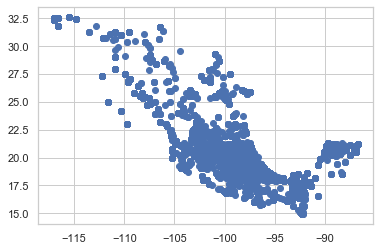

In [87]:
plt.scatter(tot_long['Lon_Decimal'],tot_long['Lat_Decimal'])

In [88]:
geop = gpd.read_file("D:/documentos/PROYECTOPERSONAL/personal/mapas/México_Centros_Urbanos.shp",encoding="latin1")
shape = shp.Reader("D:/documentos/PROYECTOPERSONAL/personal/mapas/México_Centros_Urbanos.shp",encoding="latin1")

# View the first five rows of the data
geop.head()

OBJECTID        CIUDAD MUNICIPIO           ESTADO  \
0         1       TIJUANA   TIJUANA  BAJA CALIFORNIA   
1         2        TECATE    TECATE  BAJA CALIFORNIA   
2         3      MEXICALI  MEXICALI  BAJA CALIFORNIA   
3         4  SANTA ISABEL  MEXICALI  BAJA CALIFORNIA   
4         5      PROGRESO  MEXICALI  BAJA CALIFORNIA   

                                            geometry  
0  POLYGON ((-116.8780439426812 32.54230238368538...  
1  POLYGON ((-116.5986243768981 32.57139599994107...  
2  POLYGON ((-115.3779114550664 32.66245044792393...  
3  POLYGON ((-115.5736914257759 32.64678042897413...  
4  POLYGON ((-115.57519685666 32.59689131361723, ...

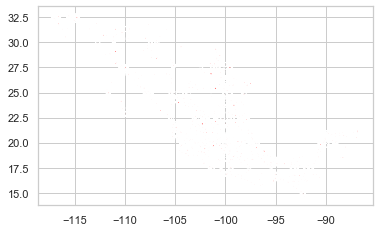

In [89]:
geop.plot(color='red',linewidth=5)

In [90]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The f

In [91]:
print(geop.crs)

{'init': 'epsg:4326'}


In [92]:
len(shape.shapes())

886

In [93]:
shape.records()

[Record #0: [1, 'TIJUANA', 'TIJUANA', 'BAJA CALIFORNIA'],
 Record #1: [2, 'TECATE', 'TECATE', 'BAJA CALIFORNIA'],
 Record #2: [3, 'MEXICALI', 'MEXICALI', 'BAJA CALIFORNIA'],
 Record #3: [4, 'SANTA ISABEL', 'MEXICALI', 'BAJA CALIFORNIA'],
 Record #4: [5, 'PROGRESO', 'MEXICALI', 'BAJA CALIFORNIA'],
 Record #5: [6, 'MORELOS', 'MEXICALI', 'BAJA CALIFORNIA'],
 Record #6: [7, 'SAN LUIS', 'TIJUANA', 'BAJA CALIFORNIA'],
 Record #7: [8, 'ROSARITO', 'TIJUANA', 'BAJA CALIFORNIA'],
 Record #8: [9, 'BENITO JUÁREZ', 'MEXICALI', 'BAJA CALIFORNIA'],
 Record #9: [10, 'HERMOSILLO', 'MEXICALI', 'BAJA CALIFORNIA'],
 Record #10: [11, 'EJIDO MICHOACÁN DE OCAMPO', 'MEXICALI', 'BAJA CALIFORNIA'],
 Record #11: [12, 'SAN LUIS RÍO COLORADO', 'SAN LUIS RIO COLORADO', 'SONORA'],
 Record #12: [13, 'EJIDO NUEVO LEÓN', 'MEXICALI', 'BAJA CALIFORNIA'],
 Record #13: [14, 'PRIMO TAPIA', 'TIJUANA', 'BAJA CALIFORNIA'],
 Record #14: [15, 'DELTA', 'MEXICALI', 'BAJA CALIFORNIA'],
 Record #15: [16, 'GUADALUPE VICTORIA', 'MEXIC

In [94]:
fields = [x[0] for x in shape.fields][1:]
records = shape.records()
shps = [s.points for s in shape.shapes()]
df = pd.DataFrame(columns=fields, data=records)
df = df.assign(coords=shps)
df

OBJECTID              CIUDAD           MUNICIPIO           ESTADO  \
0           1             TIJUANA             TIJUANA  BAJA CALIFORNIA   
1           2              TECATE              TECATE  BAJA CALIFORNIA   
2           3            MEXICALI            MEXICALI  BAJA CALIFORNIA   
3           4        SANTA ISABEL            MEXICALI  BAJA CALIFORNIA   
4           5            PROGRESO            MEXICALI  BAJA CALIFORNIA   
..        ...                 ...                 ...              ...   
881       887  SAN PEDRO POCHUTLA  SAN PEDRO POCHUTLA           OAXACA   
882       888          MAPASTEPEC          MAPASTEPEC          CHIAPAS   
883       889             HUIXTLA             HUIXTLA          CHIAPAS   
884       890           TAPACHULA           TAPACHULA          CHIAPAS   
885       891      CIUDAD HIDALGO            SUCHIATE          CHIAPAS   

                                                coords  
0    [(-116.87804394268122, 32.54230238368538), (-1...  
1    [(-116.59862437689812, 32.571395999941075), (-...  
2    [(-115.37791145506641, 32.66245044792393), (-1...  
3    [(-115.57369142577593, 32.64678042897413), (-1...  
4    [(-115.57519685665997, 32.59689131361723), (-1...  
..                                                 ...  
881  [(-96.46309315058437, 15.74604357763689), (-96...  
882  [(-92.88610615921894, 15.44604913363565), (-92...  
883  [(-92.45403073507194, 15.1487549917342), (-92....  
884  [(-92.2530242302571, 14.902242314382505), (-92...  
885  [(-92.15444946289065, 14.675832748413129), (-9...  

[886 rows x 5 columns]

In [95]:
df2=df.loc[(df['CAPITAL']=='S') | (df['CAPITAL']=='C')].reset_index()

KeyError: 'CAPITAL'

In [96]:
df2['ESTADO_low'] = list(map(lambda x: x.lower(), df2['ESTADO']))
el_low = list(map(lambda x: x.lower(), el))

NameError: name 'df2' is not defined

In [97]:
main_list = np.setdiff1d(el_low,df['ESTADO_low'])
main_list

NameError: name 'el_low' is not defined

In [ ]:
len(df2)
#df2.sort_values('ESTADO')

In [ ]:
shape.shapes()

In [ ]:
df3=pd.DataFrame(geopandas)
df3

In [ ]:
def plot_shape(id, s=None):
    """ PLOTS A SINGLE SHAPE """
    plt.figure()
    ax = plt.axes()
    ax.set_aspect('equal')
    shape_ex = shape.shape(id)
    x_lon = np.zeros((len(shape_ex.points),1))
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    plt.plot(x_lon,y_lat) 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)
    plt.text(x0, y0, s, fontsize=10)
    # use bbox (bounding box) to set plot limits
    #plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])
    return x0, y0

In [ ]:
comuna = 'Hidalgo'
com_id = df3[df3.ESTADO == comuna].index
com_id[0]
plot_shape(com_id[0], comuna)

In [ ]:
def plot_map(sf, x_lim = None, y_lim = None, figsize = (11,9)):
    '''
    Plot map with lim coordinates
    '''
    plt.figure(figsize = figsize)
    id=0
    for shape in sf.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]
        plt.plot(x, y, 'k')
        
        if (x_lim == None) & (y_lim == None):
            x0 = np.mean(x)
            y0 = np.mean(y)
            plt.text(x0, y0, id, fontsize=10)
        id = id+1
    
    if (x_lim != None) & (y_lim != None):     
        plt.xlim(x_lim)
        plt.ylim(y_lim)

In [ ]:
plot_map